In [41]:
#Import statements

#Pandas (python library for data frames), seaborn/matplotlib/plotly(visualizations), and numpy (python library for math)
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

#Imports for the models
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
pd.set_option('display.max_colwidth', None)


In [42]:
#---------------- Data Import / Cleaning ---------------------

In [43]:
#Read in data from 2019, 2020, and 2021.
df2019 =pd.read_csv('../thesis/2019.csv')
df2020 =pd.read_csv('../thesis/2020.csv')
df2021 =pd.read_csv('../thesis/2021.csv')


#Remove empty features (>90% responses missing a value for them so didn't use in analysis)
missing = ['experiences_non_participation_other','post_grad_first','how_position_other','experiences_other','post_grad_activity','field_placement']

df2019 = df2019.drop(columns=missing)
df2020 = df2020.drop(columns=missing)
df2021 = df2021.drop(columns=missing)

#Remove null lines
df2019= df2019[df2019['experiences'].notnull()]
df2020= df2020[df2020['experiences'].notnull()]
df2021= df2021[df2021['experiences'].notnull()]


In [44]:
#Uncomment the following 3 lines to show that there are a ton of typoed experiences in 2021 compared to 2020, 2019.

# print("Amount of experiences per year pre-cleaning: 2019:",df2019['experiences'].str.split('|').explode().value_counts().size, " 2020:", df2020['experiences'].str.split('|').explode().value_counts().size, " 2021:",df2021['experiences'].str.split('|').explode().value_counts().size)
# exTypos =  df2021['experiences'].str.split('|').explode().value_counts().sort_values(ascending=True)[:10].index
# print("example typos from 2021= ",exTypos[4:7])

#Clean up data by fixing typoes into categories for each year's data. 
#I found the shortened versions to use by inspecting df2021['experiences'].str.split('|').explode().value_counts() and seeing where the typoes began.

dfTemp = pd.DataFrame()
for J in range(3):
    result = []
    if(J==0): dfTemp= df2019.copy()
    if(J==1): dfTemp= df2020.copy()
    if(J==2): dfTemp= df2021.copy()
    for index, row in dfTemp.iterrows():
        experiences = row['experiences'].split('|')
        rowSize = len(experiences)
        i=1
        newExps = ''
        for exp in experiences:
            if('Study ab' in exp):
                exp='Study Abroad'
            if('Field Placement' in exp):
                exp='Field Placement'
            if('Academic research' in exp):
                exp='Research'
            if('Community s' in exp):
                exp='Community Service'
            if('Graduate assistantship' in exp or 'Teaching Assistantship' in exp):
                exp='GA/TA'
            if('Clinical' in exp):
                exp='ClinicalShadowing/Assistantship'
            if('Case comp' in exp):
                exp='Case Competition'
            if('Student org' in exp):
                exp='Student Org'
            if('On-camp' in exp or 'Employed part-ti' in exp):
                exp='EmployedCampus/Parttime'        
            if('Athl' in exp):
                exp='Athletics'  
            if('Liv' in exp or 'Residential' in exp):
                exp='RLC' 
            if('Student tea' in exp):
                exp='Student Teaching' 
            if('I did not ' in exp):
                exp='None'
            if('mentor pr' in exp or 'Mentorship' in exp):
                exp='Mentorship Program'
            if('Internship' in exp):
                exp='Internship'
            if('Cooperative education experience' in exp):
                exp='Co-op'
            if('FIGS' in exp):
                exp='FIGS'
            if('Student Access' in exp):
                exp='SAES Programs'
            if(i==rowSize):
                newExps=newExps+exp
            else:
                newExps=newExps+exp+'|'
            i=i+1
        result.append(newExps)

    if(J==0): 
        df2019['experiences']=result
    if(J==1): 
        df2020['experiences']=result
    if(J==2): 
        df2021['experiences']=result

#dfExp is an extra dataframe that you can uncomment to show the amount of experiences in each year by experience.
#For example, in 2019 3032 responses were employed on campus/parttime whereas 2432 were in 2021.
#Note some experiences only appeared in one year - for example, Work abroad doesn't appear in 2020 or 2021.
# dfExp=pd.DataFrame()

# dfExp['2019'] = df2019['experiences'].str.split('|').explode('experiences').value_counts()
# dfExp['2020'] = df2020['experiences'].str.split('|').explode('experiences').value_counts()
# dfExp['2021'] = df2021['experiences'].str.split('|').explode('experiences').value_counts()
# dfExp



In [45]:
#Combine all years data into one dataframe
df=pd.DataFrame()
df = pd.concat([df2019, df2020])
df= pd.concat([df, df2021])

#Turn experiences from form of Exp1|Exp2 into a comma separated list so easier to manipulate [Exp1, Exp2]
df['experiences']= df['experiences'].str.split('|')

#Part 1: Store the amount of rows and experiences at this point to later visualize the cleaning process.

stageOne = df.shape[0]

totalExpOne = df['experiences'].explode().value_counts().sum()

#Get rid of extra features such as codes for schools and majors
duplicates = ['school_code','major_code','major_code2']
df = df.drop(columns=duplicates)

#Get rid of graduate students
gradSchools = ['School of Graduate Studies','Graduate School of Education','Graduate School of Applied and Professional Psychology']
df = df[~df['school'].isin(gradSchools)]



#Fix school names due to typos of calling them college rather than school and extra _ spaces.
df.loc[(df['school']=='College of Engineering')|(df['school']=='School of Engineering '),'school'] = 'School of Engineering'
df.loc[(df['school']=='College of Nursing'),'school'] = 'School of Nursing'
df.loc[(df['school']=='School of Arts and Sciences '),'school'] = 'School of Arts and Sciences'
df.loc[(df['school']=='School of Social Work '),'school'] = 'School of Social Work'
df.loc[(df['school']=='Mason Gross School of the Art'),'school'] = 'Mason Gross School of the Arts'
df.loc[(df['school']=='School of Communication Information and Library Studies'),'school'] = 'School of Communication and Information'

#Change further typos of capitalizations

df['post_grad_status'] = df['post_grad_status'].replace('Seeking Employment', 'Seeking employment')
df['major'] = df['major'].replace({
    'Supply Chain and Marketing Science': 'Supply Chain And Marketing Science',
    'Labor And Employment Relations': 'Labor studies and employment relations',
    'Business Analytics And Information Technology': 'Business Analytics and Information Technology',
    'Information Technology And Informatics': 'Information Technology and Informatics',
    'Communication And Information': 'Communication and information',
    'Environmental And Business Economics': 'Environmental and business economics',
    'Electrical And Computer Engineering': 'Electrical and computer engineering',
    'Physics And Astronomy': 'Physics',
    'Biological Sciences': 'Biology',
    'Library And Information Science': 'Library and Information Science',
    'Civil & Environmental Engineering': 'Civil and Environmental Engineering',
    'Bioenvironmental Engineering': 'Bioenvironmental Engineering (Dual Degree)',
    'Bioenvironmental Engineering (Dual Degree Undergrad Program)':'Bioenvironmental Engineering (Dual Degree)',
    'Industrial And Systems Engineering': 'Industrial and Systems Engineering',
    'Women\'S And Gender Studies': 'Women\'s and Gender Studies',
    'Women\'s , Gender, and Sexuality Studies': 'Women\'s and Gender Studies',
    'Exercise Science And Sport Studies': 'Exercise Science',
    'Exercise Science / Exercise Science and Sport Studies / Exercise Science and Sport Studies': 'Exercise Science',
    'Electrical&Computer Engin (Dual Degree Undergrad Program)': 'Electrical and Computer Engineering (Dual Degree Undergrad Program)',
    'Journalism and media studies': 'Journalism and Media Studies',
    'Planning And Public Policy': 'Planning and Public Policy',
    'East Asian Languages And Studies': 'East Asian Languages and Studies',
    'Environmental Policy, Inst And Behavior': 'Environmental Policy, Inst and Behavior',
    'Music (Composition, Musicology)': 'Music (Composition, Musicology)',
    'Civil engineering': 'Civil Engineering',
    'Molecular Biology & Biochemistry': 'Molecular Biology and Biochemistry',
    'Latino and Hispanic Caribbean Studies': 'Latino and Hispanic Caribbean Studies',
    'Communication And Information': 'Communication and Information',
    'Materials Science And Engineering': 'Materials Science and Engineering',
    'chemistry': 'Chemistry'
})

#For example, uncomment the following line to show the number of Urban Planning masters students we're removing that wasn't counted as grad students earlier so we remove now:
# print("Num urban planning majors masters: ", df[df['major']=='Planning, Urban (Masters)'].size)

df = df[df['major'] != 'Planning, Urban (Masters)']

#Part 2: Store the amount of rows and experiences at this point to later visualize the cleaning process.
stageTwo = df.shape[0]
totalExpTwo = df['experiences'].explode().value_counts().sum()


In [46]:
#Remove duplicate experiences from the same row. For example: [Athletics,Athletics, Shadowing] -> [Athletics, Shadowing]

experiencesCol = []
removedDupes = []
index=0
badIndices = []
for experiencesRow in df['experiences']:
   # print(experiencesRow)
    seen = []
    result = []
    for exp in experiencesRow:
        hasSeen=False
        if exp in seen:
            removedDupes.append(exp)
            hasSeen=True
            badExp = exp
            badIndices.append(index)
        if exp not in seen:
            seen.append(exp)
            result.append(exp)
    experiencesCol.append(result)
    
    #Uncomment the following 2 lines to see examples of lines with duplicate activities in them
#     if(hasSeen):
#         print("original:",experiencesRow, "Since ",badExp,"repeated, now:",result)

    index=index+1
df['experiences']=experiencesCol
print("Removed from the above rows these duplicate experiences:",Counter(removedDupes))
df['experiences'].explode().value_counts()


#Part 3: Store the amount of rows and experiences at this point to later visualize the cleaning process.
#After removing duplicates from a row:
stageThree = df.shape[0]
totalExpThree = df['experiences'].explode().value_counts().sum()

Removed from the above rows these duplicate experiences: Counter({'EmployedCampus/Parttime': 947, 'ClinicalShadowing/Assistantship': 5})


In [47]:
#Make a list of experiences that exist in all 3 years so we can study them. For example, Work Abroad doesn't appear
#in all 3 years so we remove it here:

dfExp=pd.DataFrame()

dfExp['2019'] = df2019['experiences'].str.split('|').explode('experiences').value_counts()
dfExp['2020'] = df2020['experiences'].str.split('|').explode('experiences').value_counts()
dfExp['2021'] = df2021['experiences'].str.split('|').explode('experiences').value_counts()
dfExp=dfExp.dropna()

ValidVariables = dfExp.index


# Remove rows with invalid experiences (i.e. experiences that aren't in all 3 years)
def removeNonFocusedExperiences(row):
    c=True
    for exp in row:
        if exp not in ValidVariables:
            c = False
    return c
df=df[df['experiences'].apply(removeNonFocusedExperiences)]

#Part 4: Store the amount of rows and experiences at this point to later visualize the cleaning process.
#After removing rows with invalid experiences
stageFour = df.shape[0]
totalExpFour = df['experiences'].explode().value_counts().sum()


#Remove null value rows
df=df[(df['post_grad_choice'].notnull()) & (df['experiences'].notnull())]

#Part 5: Store the amount of rows and experiences at this point to later visualize the cleaning process.
#After removing null rows
stageFive = df.shape[0]
totalExpFive = df['experiences'].explode().value_counts().sum()
dfExp

,2019,2020,2021
EmployedCampus/Parttime,3032,3197.0,2432.0
Internship,2586,2395.0,2452.0
Student Org,2381,1689.0,1028.0
Community Service,1469,1224.0,862.0
Research,1063,1006.0,344.0
None,745,475.0,601.0
Athletics,681,640.0,323.0
Field Placement,616,503.0,430.0
Study Abroad,494,351.0,226.0
ClinicalShadowing/Assistantship,328,343.0,581.0


In [48]:
#Part 6: Store the amount of rows and experiences at this point to later visualize the cleaning process.
#Removing the people who said no to are you satisfied with your status and yet still preferred their current status.
df=df[~((df['post_grad_choice']=='No') & (df['post_grad_prefer']==df['post_grad_status']))]
totalExpSix = df['experiences'].explode().value_counts().sum()
stageSix = df.shape[0]


#Part 7: Store the amount of rows and experiences at this point to later visualize the cleaning process.
#Removing the people who said they are satisfied with their status yet still have a preferred status.
df= df[~((df['post_grad_prefer'].notnull()) & (df['post_grad_choice']=='Yes'))]
totalExpSeven = df['experiences'].explode().value_counts().sum()
stageSeven = df.shape[0]



In [49]:
#Visualize the cleaning by row

data = dict(
    number=[stageOne, stageTwo, stageThree, stageFour,stageFive,stageSix,stageSeven],
    stage=["Starting Data", "No Graduate Students", "Removing duplicate entries same row", "Removing rows with bad variables","Removing null rows","No but prefer current status","Yes but have preferred"])
fig = px.funnel(data, x='number', y='stage', title='Rows in dataframe during cleaning')
fig.show()

In [50]:
data = dict(
    number=[totalExpOne, totalExpTwo, totalExpThree, totalExpFour,totalExpFive, totalExpSix,totalExpSeven],
    stage=["Starting Data", "No Graduate Students", "Removing duplicate entries same row", "Removing rows with bad variables","Removing null rows","No but prefer current status","Yes but have preferred"])
fig = px.funnel(data, x='number', y='stage',title='Total experiences in dataframe during cleaning')
fig.show()

In [51]:
#---------------- Visualizations ---------------------

In [52]:
#Part 1: General visualizations ---------

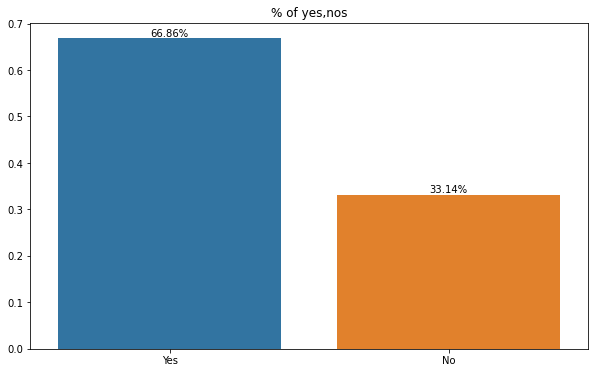

In [53]:
#Graph 1

#What % replied yes and no

yesAndNos = pd.DataFrame(columns=['Yes','No'])
yesAndNos['Yes']= [df[df['post_grad_choice']=='Yes'].shape[0]/df.shape[0]]
yesAndNos['No']= [df[df['post_grad_choice']=='No'].shape[0]/df.shape[0]]


fig, ax = plt.subplots(figsize=(10, 6))
barplot = sns.barplot(data=yesAndNos)
bar_heights = [bar.get_height() for bar in barplot.containers[0]]
for i, height in enumerate(bar_heights):
    barplot.text(i, height, f"{height:.2%}", ha='center', va='bottom')
barplot.set_title('% of yes,nos')
plt.show()

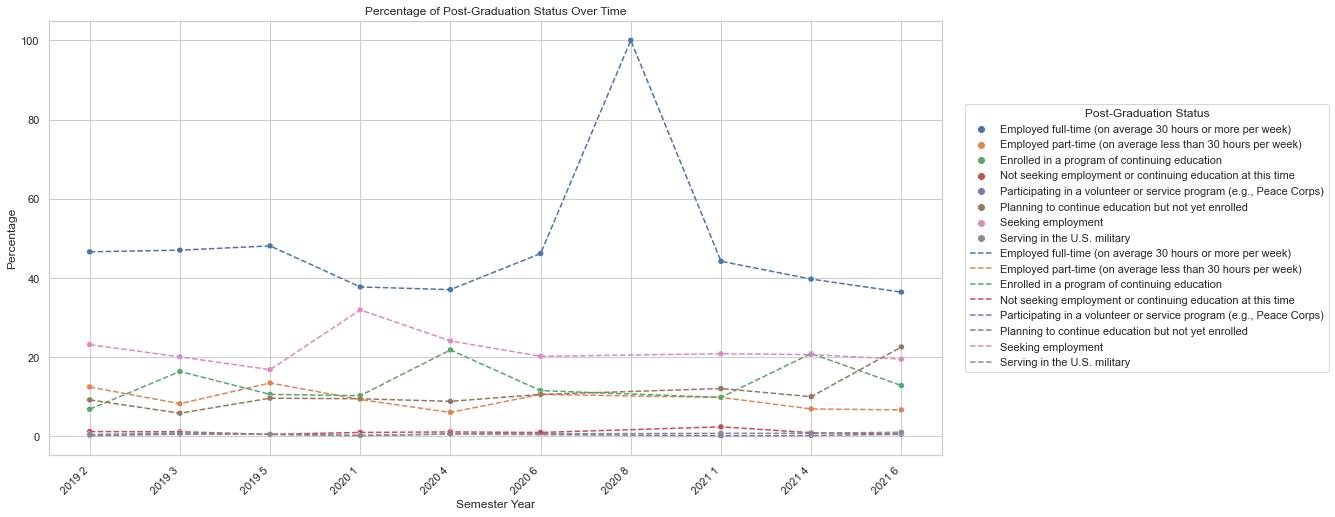

In [54]:
#Graph 2: % in each post_grad_status by year and semester
filtered_df = df.copy()
filtered_df['survey_year'] = filtered_df['survey_year'].astype(str)
filtered_df['survey_semester'].fillna('0', inplace=True)

semester_order = {'January': 1, 'Winter': 2, 'Spring': 3, 'May': 4, 'Summer': 5, 'August': 6, 'Fall': 7, 'October': 8}

#Make a new column semester that's the numerical version of the semester so we can sort it.
filtered_df['semester'] = filtered_df['survey_semester'].map(semester_order)

# Create a combined column of semester and year for categorical x-axis
filtered_df['year_semester'] = filtered_df['survey_year']+ ' ' + filtered_df['semester'].map(str)
grouped_df = filtered_df.groupby(['year_semester', 'post_grad_status']).size().reset_index(name='count')
grouped_df
total_count_by_year_semester = grouped_df.groupby('year_semester')['count'].transform('sum')
grouped_df['percentage'] = grouped_df['count'] / total_count_by_year_semester * 100

sns.set(style='whitegrid')
plt.figure(figsize=(16, 8))
sns.scatterplot(x='year_semester', y='percentage', hue='post_grad_status', data=grouped_df)
plt.title('Percentage of Post-Graduation Status Over Time')
plt.xlabel('Semester Year')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Post-Graduation Status')

for status in grouped_df['post_grad_status'].unique():
    sns.lineplot(x='year_semester', y='percentage', data=grouped_df[grouped_df['post_grad_status'] == status],
                 label=status, linestyle='--', ci=None)
plt.legend(title='Post-Graduation Status', bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.show()

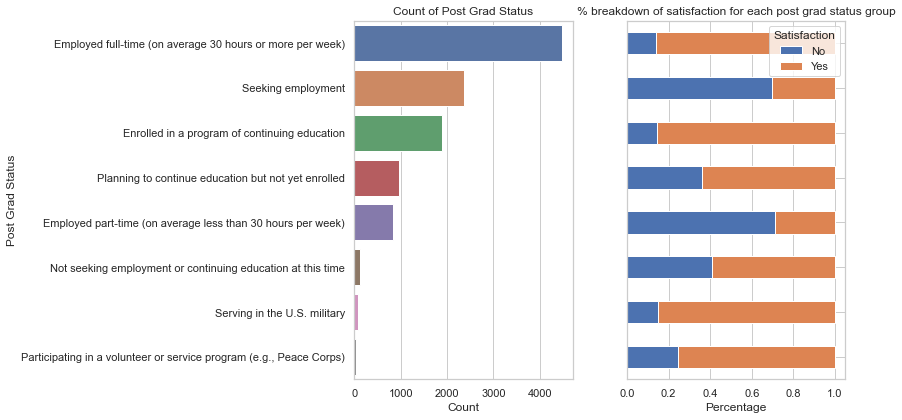

In [55]:
#Graph 3/4: Showing the amount in each post-grad status from the respondents and then what % of that status category is satisfied.

#Set the order to graph the statuses in descending order of valuecounts
orderCategory = df['post_grad_status'].value_counts().index.tolist()[::-1]

# Count the number of satisfied and unsatisfied responses within each post_grad_status group
satisfaction_counts = df.groupby(['post_grad_status', 'post_grad_choice'])['post_grad_choice'].count().unstack().fillna(0)

# Turn the count into % satisfied and % unsatisfied
satisfaction_percents = satisfaction_counts.apply(lambda x: x / x.sum(), axis=1)

# Reorder the rows to be the same as orderCategory
satisfaction_percents = satisfaction_percents.reindex(orderCategory)

#Get the order of the statuses in a list
orderCategory = df['post_grad_status'].value_counts().index.tolist()

# Plot the two graphs separately
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the count of post grad status
sns.countplot(data=df, y='post_grad_status', ax=axs[0], order = orderCategory)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Post Grad Status')
axs[0].set_title('Count of Post Grad Status')

# Plot the % breakdown of satisfaction for each post grad status group
satisfaction_percents.plot(kind='barh', stacked=True, ax=axs[1])
axs[1].set_xlabel('Percentage')
axs[1].set_title("% breakdown of satisfaction for each post grad status group")
axs[1].legend(title='Satisfaction', loc='upper right')


# Get rid of unnecessary labels and ticks
axs[1].set_ylabel('')
axs[1].set_yticklabels('')

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

plt.show()



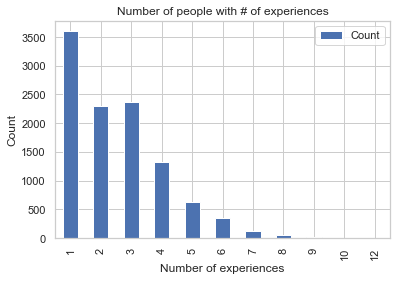

In [56]:
#Graph 5: Number of experiences

#Get # experiences in each response
experiences_length = df['experiences'].apply(len)

# Get avg satisfaction of someone who did that # of experiences (for example if you did 2 experiences, 64% chance on average you'll be satisfaction)
percentages_with_postgrad = df.groupby(experiences_length)['post_grad_choice'].apply(lambda x: (x == 'Yes').mean() * 100).to_frame()

# Count # people with that # experiences
counts_by_experience = experiences_length.value_counts()

# Combine the two into a new DataFrame
results = pd.concat([percentages_with_postgrad, counts_by_experience], axis=1)

# Rename the columns of the combined DataFrame
results.columns = ['percent_satisfied', 'count_by_experience']

# create the bar chart
ax = results.plot(kind='bar', y='count_by_experience', color='C0')

# set labels and legends
ax.set_xlabel('Number of experiences')
ax.set_ylabel('Count')
ax.legend(['Count'])
ax.set_title("Number of people with # of experiences")
plt.show()


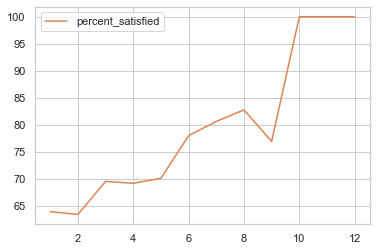

In [57]:
#Graph 6: Satisfaction % to # of experiences
ax=results.plot(kind='line', y='percent_satisfied', color='C1')
plt.show()

(array([   0.,  500., 1000., 1500.]),
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

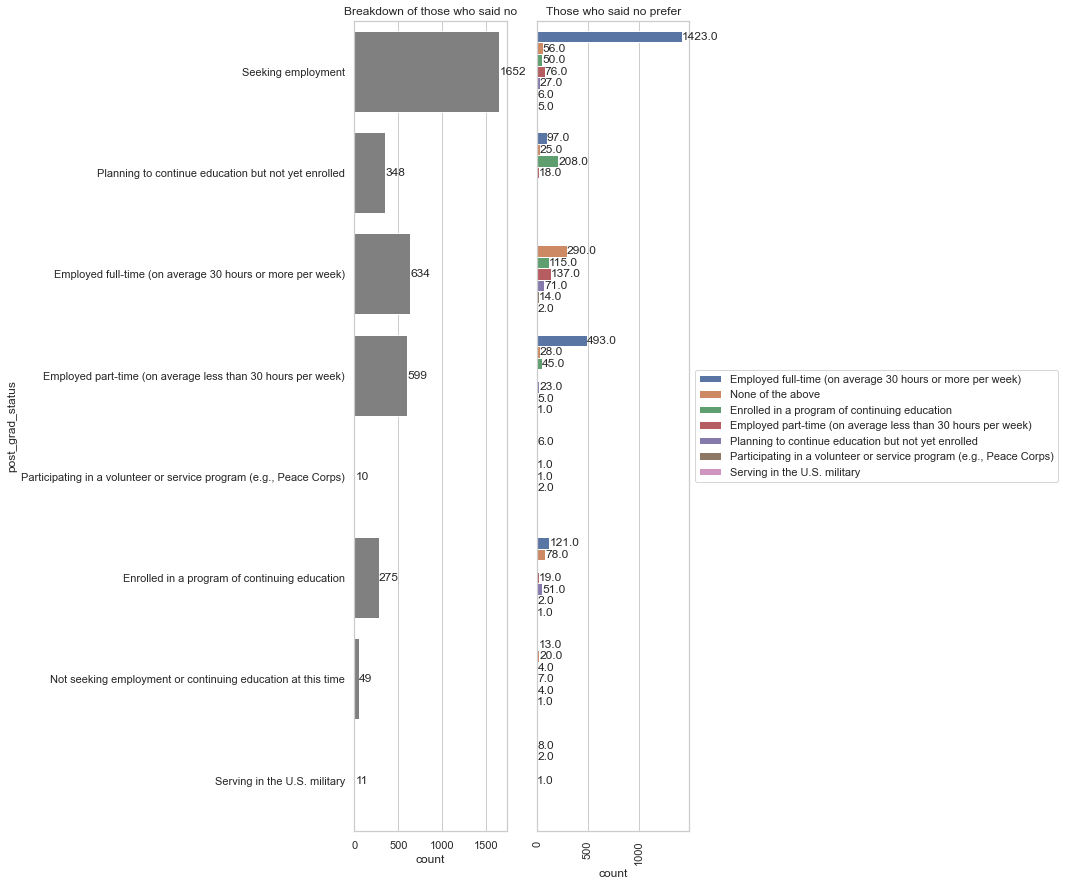

In [58]:
#Graph 7: What do people prefer for their status?

#What do current status people prefer?

hue_order = df[df['post_grad_choice']=='No']['post_grad_prefer'].value_counts().index.tolist()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,6))


countplot1 = sns.countplot(data=df[df['post_grad_choice']=='No'], y='post_grad_status', ax=axs[0],palette=['grey'])
for bar in countplot1.containers:
    for rect in bar.patches:
        count = rect.get_width()
        if count > 0:
            axs[0].text(count, rect.get_y() + rect.get_height() / 2, count, ha='left', va='center')
countplot1.set_title("Breakdown of those who said no")

countplot2 = sns.countplot(data=df[df['post_grad_choice']=='No'], y='post_grad_status', hue='post_grad_prefer',hue_order=hue_order, ax=axs[1])
for bar in countplot2.containers:
    for rect in bar.patches:
        count = rect.get_width()
        if count > 0: 
            axs[1].text(count, rect.get_y() + rect.get_height() / 2, count, ha='left', va='center')
countplot2.set_title("Those who said no prefer")
countplot2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_ylabel('') # remove y-axis label for the second plot in row 2
axs[1].set_yticklabels([])

plt.subplots_adjust(top=2)
plt.xticks(rotation=90)


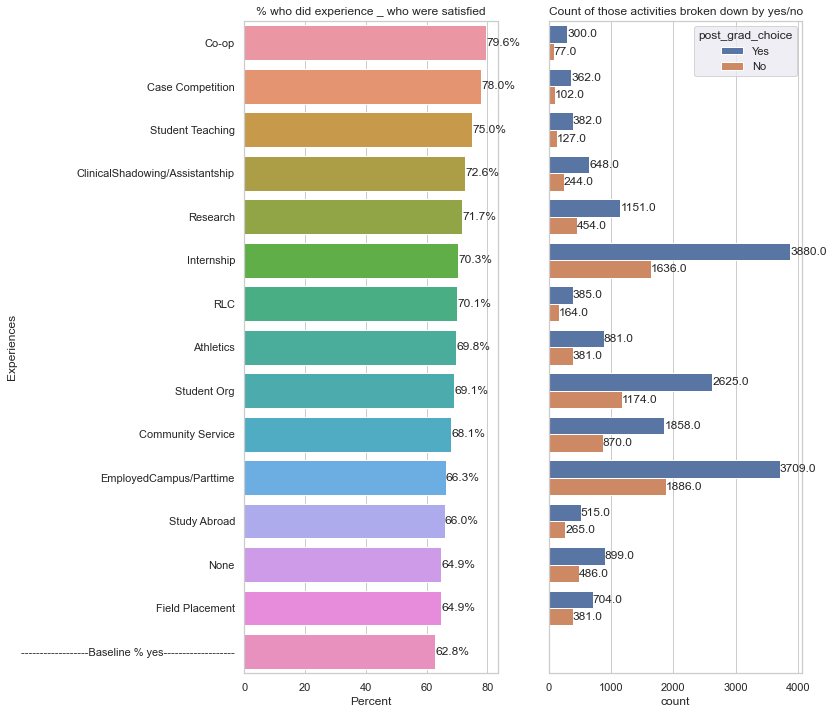

In [59]:
#Graph 8/9: What % of those who did experience _ were satisfied, and counts of yes/no per experience.

percents =pd.DataFrame(columns=['Experiences','Percent'])
percents['Experiences']=ValidVariables
pcts = []
totals = []

for exp in ValidVariables:
    mask = df['experiences'].apply(lambda x: exp in x)
    numExp=df[mask].shape[0]
    numExpYes = df[mask][df[mask]['post_grad_choice']=='Yes'].shape[0]
    pcts.append(100* numExpYes/numExp)
    totals.append(numExp)
percents['Percent']=pcts
lastRow=percents.shape[0]-1
percents.iloc[lastRow]=['------------------Baseline % yes-------------------',0.627855*100]
percents['Total'] = totals
percents=percents.sort_values(by='Percent',ascending=False)


#Sort plotdfExp in order of percents to show side by side % vs counts in df on 2ndgraph
fig, axs = plt.subplots(ncols=2, figsize=(10,12))

ax1= sns.barplot(data=percents,y='Experiences',x='Percent', orient = 'h',ax=axs[0])
for c in ax1.containers:
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h:0.1f}%' if (h := v.get_width()) > 0 else '' for v in c]
    ax1.bar_label(c, labels=labels, label_type='edge')
ax1.set_title('% who did experience _ who were satisfied')


sns.set(rc={'figure.figsize':(11.7,8.27)})

exps = pd.DataFrame()
exps = df.copy(deep=True)
exps['experiences']=exps['experiences']
ax2= sns.countplot(data=exps[['experiences','post_grad_choice']].explode('experiences'),y='experiences', hue = 'post_grad_choice',order = percents['Experiences'], ax=axs[1])
ax2.set(yticklabels=[])
ax2.set(ylabel='')
ax2.set_title('Count of those activities broken down by yes/no')

for c in ax2.containers:
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h}' if (h := v.get_width()) > 0 else '' for v in c]
    ax2.bar_label(c, labels=labels, label_type='edge')

plt.show()


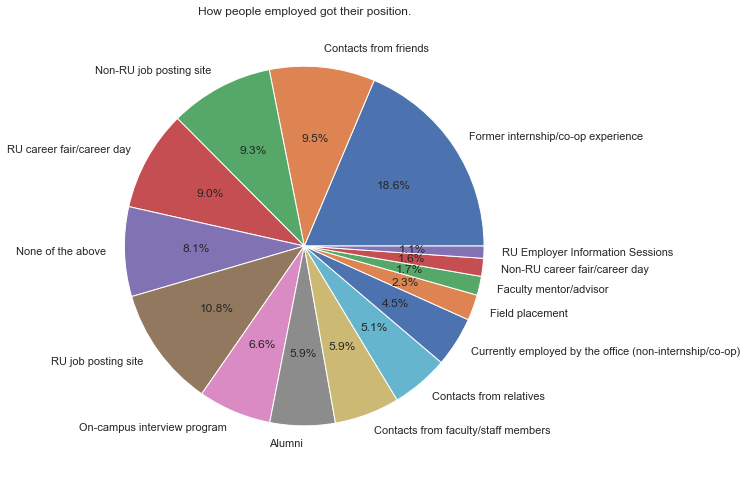

,index,how_position
0,Former internship/co-op experience,1282
1,Contacts from friends,652
2,Non-RU job posting site,642
3,RU career fair/career day,621
4,None of the above,554
5,RU job posting site,744
6,On-campus interview program,452
7,Alumni,403
8,Contacts from faculty/staff members,403
9,Contacts from relatives,354


In [60]:
#Graph 10: How did people get their position

hows= df['how_position'].str.split('|').explode().value_counts().to_frame().reset_index()

#Combine the typos of RU job posting site together along with faculty connections typoes
hows.iloc[5]= ['RU job posting site',hows.iloc[5]['how_position']+hows.iloc[11]['how_position']]
hows = hows.drop(index=11)
hows.iloc[8]= ['Contacts from faculty/staff members',hows.iloc[8]['how_position']+hows.iloc[16]['how_position']]
hows = hows.drop(index=16)
hows=hows[:15]

# Create the pie plot
plt.pie(hows['how_position'], labels=hows['index'], autopct='%1.1f%%')
plt.title("How people employed got their position.")
plt.show()

hows


Text(0.5, 1.0, 'Percentage of people seeking employment by experience')

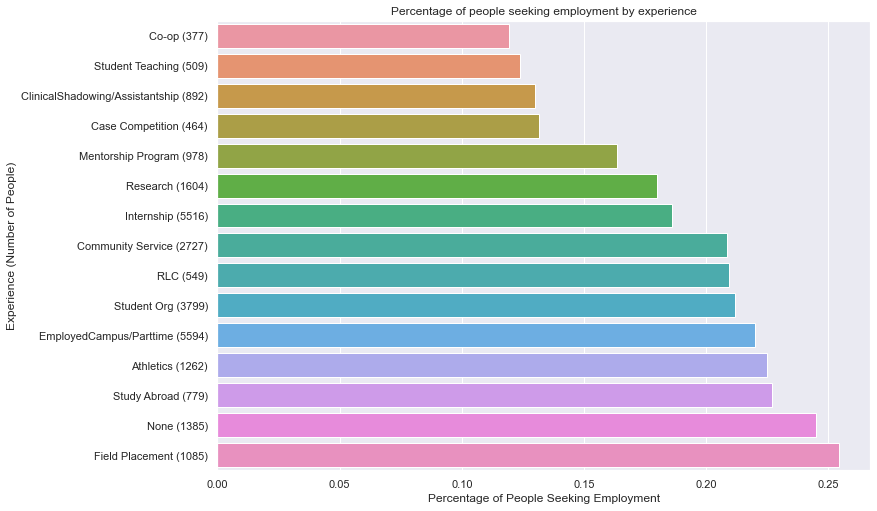

In [61]:
#Graph 11: How many of each activity are seeking employment

df2 = df.copy()

# Make new col with , separated experience
df2['Experiences_str'] = df2['experiences'].apply(lambda x: ','.join(x))

exploded = df2.explode('experiences')

# Calculate the % seeking employment by expeirence
seeking_employment_perc = exploded.groupby('experiences')['post_grad_status'].apply(lambda x: (x == 'Seeking employment').sum() / len(x)).reset_index(name='Seeking_Employment_Perc')

# Calculate num people who did each experience
num_people = exploded.groupby('experiences')['post_grad_status'].count().reset_index(name='Num_People')

# Merge the seeking employment % and num people DataFrames
merged = pd.merge(seeking_employment_perc, num_people, on='experiences')

# Sort the data in ascending 
merged = merged.sort_values(by='Seeking_Employment_Perc')

sns.barplot(y='experiences', x='Seeking_Employment_Perc', data=merged, order=merged['experiences'])

# Add the number of people who did each experience to the y-axis label
labels = [f"{exp} ({num})" for exp, num in zip(merged['experiences'], merged['Num_People'])]
plt.yticks(range(len(labels)), labels)

plt.xlabel('Percentage of People Seeking Employment')
plt.ylabel('Experience (Number of People)')
plt.title('Percentage of people seeking employment by experience')


In [62]:
#Graph 12: % satisfaction by survey semester and year
df['survey_semester'].value_counts()
df.groupby(['survey_year', 'survey_semester'])['post_grad_choice'].value_counts(normalize=True)


survey_year  survey_semester  post_grad_choice
2019         Spring           Yes                 0.688238
                              No                  0.311762
             Summer           Yes                 0.687500
                              No                  0.312500
             Winter           Yes                 0.649852
                              No                  0.350148
2020         August           Yes                 0.615385
                              No                  0.384615
             January          Yes                 0.576402
                              No                  0.423598
             May              Yes                 0.662301
                              No                  0.337699
             October          Yes                 1.000000
2021         August           Yes                 0.682051
                              No                  0.317949
             January          Yes                 0.662202
         

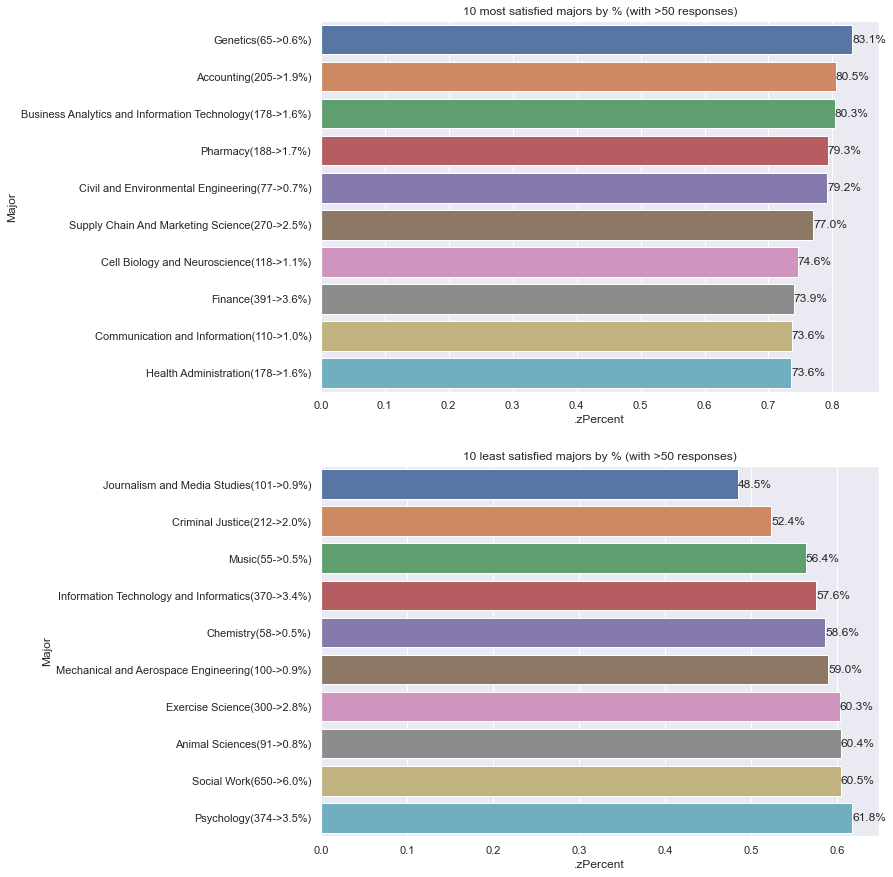

In [63]:
#Graph 13/14: Happiest and least happy majors

#What are the % happiness by major?
happyByMajor = pd.DataFrame(columns=['Major', 'Count', '.zPercent'])
for major in df['major'].value_counts().index: 
    numMajor = df[df['major']==major].shape[0]
    numHappy = df[(df['major']==major)& (df['post_grad_choice']=='Yes')].shape[0]
    percHappy = numHappy/numMajor
    totalMajors = df['major'].value_counts().sum()
    major = major+'('+str(numMajor)+'->'+str("%.1f" %(100*(numMajor/totalMajors)))+'%'+')'
    row= [major, numMajor, percHappy]
    happyByMajor.loc[len(happyByMajor)]= row

fig, axs = plt.subplots(nrows=2, figsize=(10,15))

ax1=sns.barplot(data=happyByMajor[happyByMajor['Count']>50], y='Major',x='.zPercent', order= happyByMajor[happyByMajor['Count']>50].sort_values(by=['.zPercent','Count'],ascending=False)['Major'][:10], ax=axs[0])
ax1.set_title("10 most satisfied majors by % (with >50 responses)")
ax2= sns.barplot(data=happyByMajor[happyByMajor['Count']>50], y='Major',x='.zPercent', order= happyByMajor[happyByMajor['Count']>50].sort_values(by=['.zPercent','Count'],ascending=True)['Major'][:10], ax=axs[1])
ax2.set_title("10 least satisfied majors by % (with >50 responses)")
for c in ax1.containers:
    labels = [f'{100*h:0.1f}%' if (h := v.get_width()) >= 0 else '' for v in c]
    ax1.bar_label(c, labels=labels, label_type='edge')
for c in ax2.containers:
    labels = [f'{100*h:0.1f}%' if (h := v.get_width()) >= 0 else '' for v in c]
    ax2.bar_label(c, labels=labels, label_type='edge')

plt.show()


31


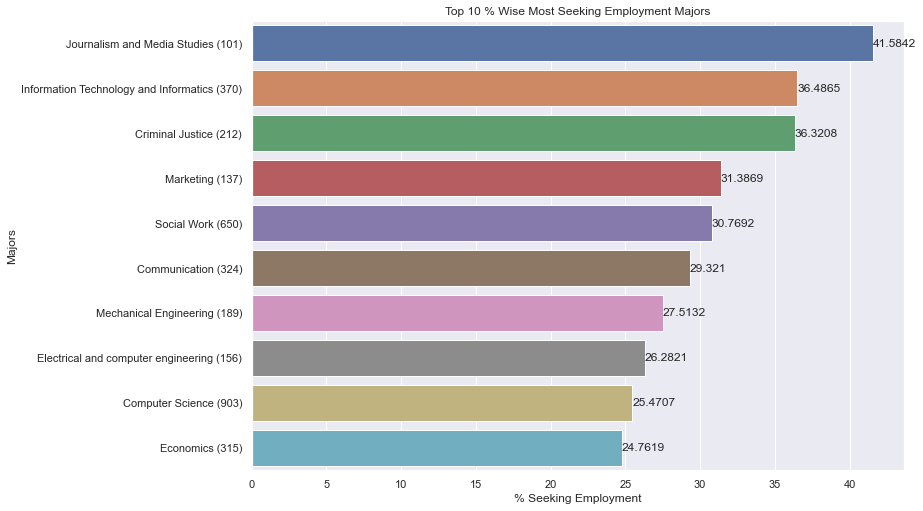

<Figure size 864x432 with 0 Axes>

In [64]:
#Graph 15: Top 10 % seeking employment majors

# Create an empty DataFrame with the desired columns
majorData = pd.DataFrame(columns=['Majors', 'Count', 'NumUnemployed', '%Unemployed'])

# Iterate over the majors
for major in df['major'].unique():
    # Get the count of responses from the current major
    count = len(df[df['major'] == major])
    
    # Get the count of responses from the current major with post_grad_status == 'Seeking employment'
    numUnemployed = len(df[(df['major'] == major) & (df['post_grad_status'] == 'Seeking employment')])
    
    # Calculate the % unemployed
    percUnemployed = 100 * numUnemployed / count
    
    # Create a new dataframe with the data for the current major
    new_data = pd.DataFrame({'Majors': [major], 'Count': [count], 'NumUnemployed': [numUnemployed], '%Unemployed': [percUnemployed]})
    
    # Concatenate the new dataframe with the majorData dataframe
    majorData = pd.concat([majorData, new_data], ignore_index=True)

majorData = majorData.sort_values('Count', ascending=False)


# Get the top 10 % wise most seeking unemployment majors with count > 50
top_10_majors = majorData[majorData['Count'] > 100].sort_values('%Unemployed', ascending=False).head(10)
print(len(majorData[majorData['Count'] > 100]))
topMajorsEmploy = top_10_majors['Majors']
top_10_majors['Majors'] = top_10_majors.apply(lambda row: f"{row['Majors']} ({row['Count']})", axis=1)

# Create a bar plot using Seaborn
ax = sns.barplot(x="%Unemployed", y="Majors", data=top_10_majors)
plt.figure(figsize=(12,6))

# Add labels to the plot
ax.set_xlabel("% Seeking Employment")
ax.set_ylabel("Majors")
ax.set_title("Top 10 % Wise Most Seeking Employment Majors")

# Add the count of each major next to the bars
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label=str(top_10_majors['NumUnemployed'].iloc[i]), label_type='edge')


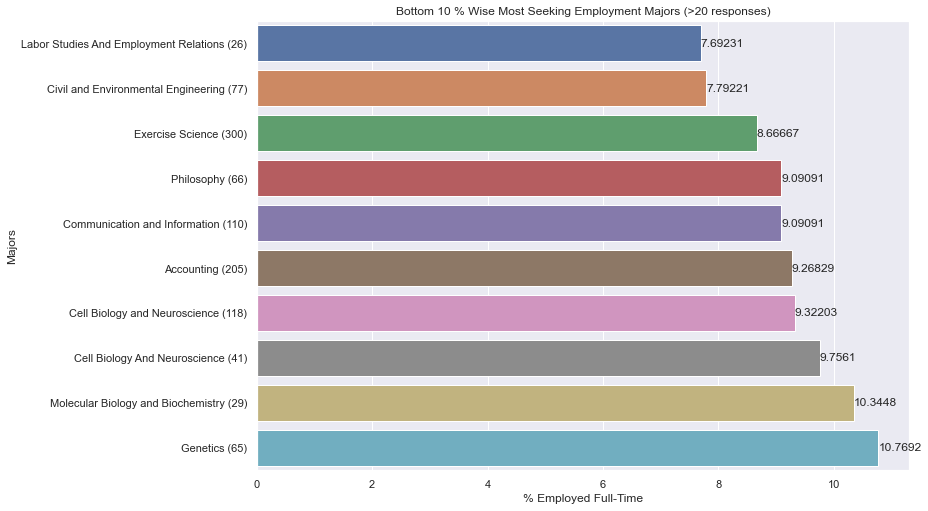

<Figure size 864x432 with 0 Axes>

In [65]:
#Graph 16: Bottom 10% seeking employment majors
majorData = pd.DataFrame(columns=['Majors', 'Count', 'NumEmployed', '%Employed'])

# Iterate over the majors
for major in df['major'].unique():
    # Get the count of responses from the current major
    count = len(df[df['major'] == major])
    
    # Get the count of responses from the current major with post_grad_status == 'Employed Full-Time'
    numEmployed = len(df[(df['major'] == major) & (df['post_grad_status'] == 'Seeking employment')])
    
    # Calculate the percentage of employed full-time
    percEmployed = 100 * (numEmployed / count)
    
    # Create a new dataframe with the data for the current major
    new_data = pd.DataFrame({'Majors': [major], 'Count': [count], 'NumEmployed': [numEmployed], '%Employed': [percEmployed]})
    
    # Concatenate the new dataframe with the majorData dataframe
    majorData = pd.concat([majorData, new_data], ignore_index=True)

majorData = majorData.sort_values('Count', ascending=False)

# Get the top 10 % wise most full-time employed majors with count > 100
top_10_majors = majorData[majorData['Count'] > 20].sort_values('%Employed', ascending=True).head(10)
topMajorsEmploy = top_10_majors['Majors']
top_10_majors['Majors'] = top_10_majors.apply(lambda row: f"{row['Majors']} ({row['Count']})", axis=1)

# Create a bar plot using Seaborn
ax = sns.barplot(x="%Employed", y="Majors", data=top_10_majors)
plt.figure(figsize=(12,6))

# Add labels to the plot
ax.set_xlabel("% Employed Full-Time")
ax.set_ylabel("Majors")
ax.set_title("Bottom 10 % Wise Most Seeking Employment Majors (>20 responses)")

# Add the count of each major next to the bars
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label=str(top_10_majors['NumEmployed'].iloc[i]), label_type='edge')


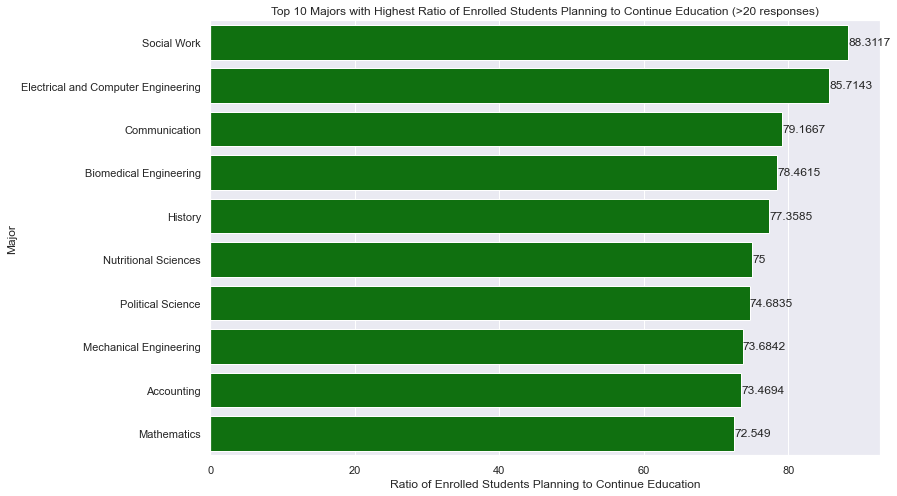

In [66]:
#Graph 17: Top 10 majors with ratio of grad school competitiveness

# Create an empty DataFrame with the desired columns
majorData = pd.DataFrame(columns=['Majors', 'CountFurtherEducation', 'NumPlanning', '%EnrolledWhoWantTo'])

# Iterate over the majors
for major in df['major'].unique():
    # Get the count of responses from the current major
    count = len(df[(df['major'] == major) & (df['post_grad_status']=='Enrolled in a program of continuing education')])
    
    # Get the count of responses from the current major with post_grad_status == 'Planning to continue education but not yet enrolled'
    numPlanning = len(df[(df['major'] == major) & (df['post_grad_status'] == 'Planning to continue education but not yet enrolled')])
    
    # Calculate the percentage of responses planning to continue education but not yet enrolled
    if numPlanning == 0:
        percPlanning = 0
    else:
        percPlanning = 100 * count / (numPlanning + count)
    
    # Create a new dataframe with the data for the current major
    new_data = pd.DataFrame({'Majors': [major], 'CountFurtherEducation': [count], 'NumPlanning': [numPlanning], '%EnrolledWhoWantTo': [percPlanning]})
    
    # Concatenate the new dataframe with the majorData dataframe
    majorData = pd.concat([majorData, new_data], ignore_index=True)

majorData = majorData.sort_values('CountFurtherEducation', ascending=False)

# Filter the data for majors with count > 20
filtered_major_data = majorData[majorData['CountFurtherEducation'] > 20]

# Get the top 10 majors with the highest ratio of enrolled students who want to continue education
top_10_majors = filtered_major_data.sort_values('%EnrolledWhoWantTo', ascending=False).head(10)

# Create a barplot for the top 10 majors
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
ax=sns.barplot(x='%EnrolledWhoWantTo', y='Majors', data=top_10_majors, color='green')
plt.title('Top 10 Majors with Highest Ratio of Enrolled Students Planning to Continue Education (>20 responses)')
plt.xlabel('Ratio of Enrolled Students Planning to Continue Education')
plt.ylabel('Major')

# Add the count of each major next to the bars
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label=str(top_10_majors['Majors'].iloc[i]), label_type='edge')


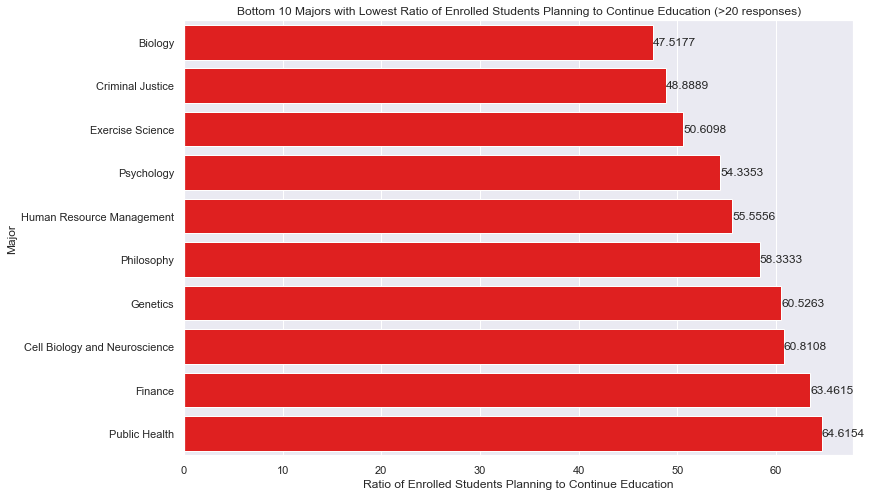

In [67]:
#Graph 18: Bottom 10 majors by graduate school competitiveness (i.e. ratio of wanting to go vs being in)

# Get the bottom 10 majors with the lowest ratio of enrolled students who want to continue education
bottom_10_majors = filtered_major_data.sort_values('%EnrolledWhoWantTo').head(10)

# Create a barplot for the bottom 10 majors
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
ax= sns.barplot(x='%EnrolledWhoWantTo', y='Majors', data=bottom_10_majors, color='red')
plt.title('Bottom 10 Majors with Lowest Ratio of Enrolled Students Planning to Continue Education (>20 responses)')
plt.xlabel('Ratio of Enrolled Students Planning to Continue Education')
plt.ylabel('Major')


# Add the count of each major next to the bars
for i, bar in enumerate(ax.containers):
    ax.bar_label(bar, label=str(bottom_10_majors['Majors'].iloc[i]), label_type='edge')


Text(0.5, 1.0, 'Reasons for non-participation')

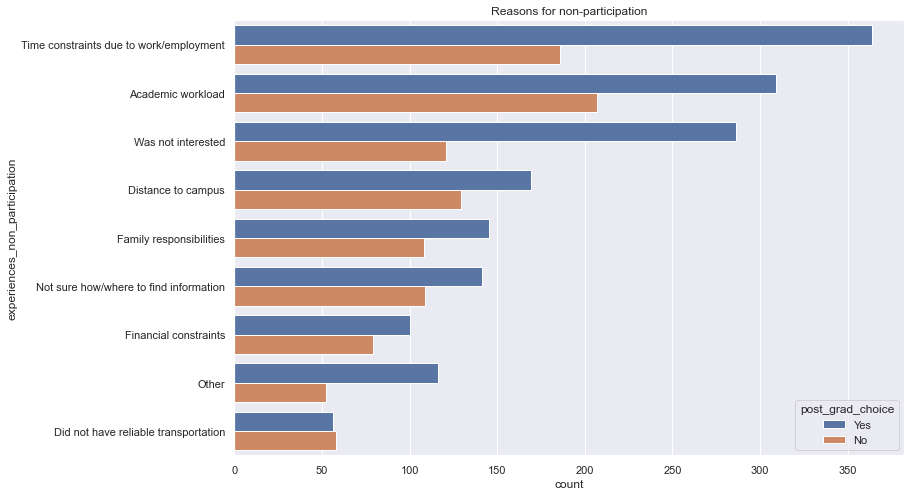

In [68]:
#Graph 19: Reasons not doing any experience

# Split the values in the 'experiences_non_participation' column on '|'
exploded = df['experiences_non_participation'].str.split('|', expand=True)

# Duplicate the other columns of the original DataFrame
other_cols = df[['post_grad_choice']].values.repeat(exploded.shape[1], axis=0)

# Flatten the exploded values into a single column and add it to the other columns
new_df = pd.DataFrame({'experiences_non_participation': exploded.values.flatten(),
                       'post_grad_choice': other_cols.flatten()})

# Create the barplot with count on x-axis, reason on y-axis and hue as post_grad_choice
sns.countplot(data=new_df[new_df['experiences_non_participation'].isin(new_df['experiences_non_participation'].value_counts()[:9].index)], y='experiences_non_participation', hue='post_grad_choice',order =new_df['experiences_non_participation'].value_counts().sort_values(ascending=False)[:9].index).set_title("Reasons for non-participation")


In [69]:
#Graph 20: Get majors with highest count of the top 10 reasons not doing any activity

# Drop rows with missing values in 'experiences_non_participation' or 'major' column
df_cleaned = df.dropna(subset=['experiences_non_participation', 'major'])

# Get the top 10 values from the 'experiences_non_participation' column
top_10_values = df_cleaned['experiences_non_participation'].str.split('|').explode().value_counts()[:10].index

result = {}
for value in top_10_values:
    # Filter rows containing the current value
    filtered_df = df_cleaned[df_cleaned['experiences_non_participation'].str.contains(value)]
    # Count the occurrences of each 'major'
    major_counts = filtered_df['major'].value_counts()
    if not major_counts.empty:
        # Get the 'major' with the highest count
        major_with_highest_count = major_counts.idxmax()
        result[value] = major_with_highest_count
    else:
        result[value] = np.nan  # or any desired value to represent missing data

result

{'Time constraints due to work/employment': 'Library and Information Science',
 'Academic workload': 'Computer Science',
 'Was not interested': 'Computer Science',
 'Distance to campus': 'Library and Information Science',
 'Family responsibilities': 'Computer Science',
 'Not sure how/where to find information': 'Computer Science',
 'Financial constraints': 'Computer Science',
 'Other': 'Computer Science',
 'Did not have reliable transportation': 'Information Technology and Informatics',
 'Already employed': 'Communication and Information'}

In [70]:
#Part 2: ------Specific Visualizations-------

In [71]:
#Make major group categories corresponding to part 1 of my thesis using the same majors as gotten from the survey.

eng = ['Aerospace Engineering','Computer Science','Mathematics',
       'Chemical Engineering','Materials Science and Engineering',
      'Engineering (Including computer science)','BME',
      'civil Engineering ',
       'Civil Engineering',
       'Mechanical Engineering',
      'Computer Science, Mathematics',
       'Computer Science, Math',
       'ITI',
       'Plant Biotechnology'
      ]
sciences = ['Pharmacy',
           'Cell Biology and Neuroscience',
            'Public Health',
           'Biology','Cell Biology',
            'Sciences (Bio, Chem, Physics, Environmental, et.)',
            'My expected major is forensic chemistry',
            'Genetics',
            'Exercise Science'
           ]
business = [
    'Business (Finance, Supply chain, et.)',
    'Finance',
    'Supply chain',
    'Accounting'
]
humanities = [
    'Arts & Humanities (Philosophy, Literature, Language, et.)',
    'Philosophy',
    'History',
    'English',
    'Communication'
]
socialSciences = [
    'Social Sciences (Economics, Anthropology, Geography, Polysci, Sociology, et.)',
    'Psychology',
    'Social Work',
    'Criminal Justice and psych ',
    'Human Resource Management, Psychology ',
    'Psychology and Cognitive Science ',
    'Psychology & Social Work',
    'Gender Studies',
    'Cognitive Science'
    'Cognitive Science / Psychology'
]
undecided = [
    'Undecided'
]
performingArts = [
    'Digital Filmmaking',
    'Music Education'
]


special = [
    'Arts & Humanities (Philosophy, Literature, Language, et.),Social Sciences (Economics, Anthropology, Geography, Polysci, Sociology, et.)',
       'Social Sciences (Economics, Anthropology, Geography, Polysci, Sociology, et.),Business (Finance, Supply chain, et.)',
       'Public health and cognitive science ',
       'Math, Statistics, Economics', 'Nursing',
       'Biological Sciences, Psychology', 'exercise science, psychology',
       'Public Health and History (double)', 'Genetics and Psychology ',
       'Psychology and Music Education/Performance',
       'Philosophy and Political Science', 'nursing '
]

Text(0.5, 1.0, '% of group satisfied with post_grad status')

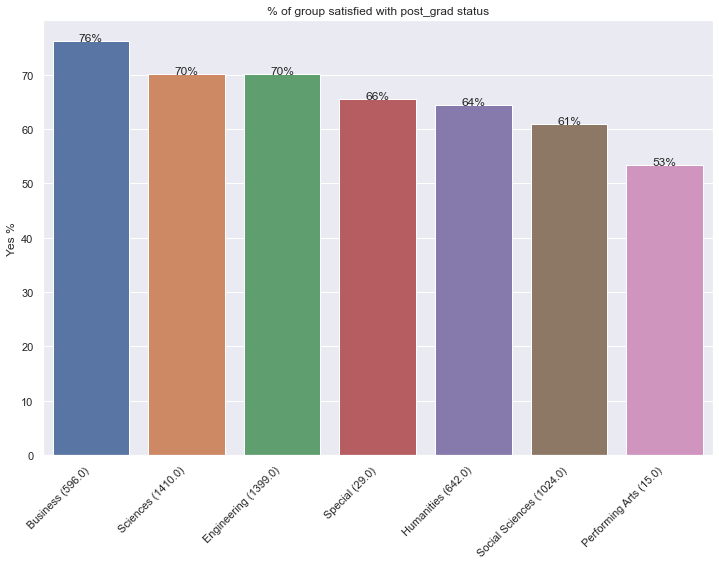

In [72]:
#Graph 21: Plot each major group by % satisfied

# Create a dictionary to store major groups and their corresponding majors
major_groups = {
    'Engineering': eng,
    'Sciences': sciences,
    'Business': business,
    'Humanities': humanities,
    'Social Sciences': socialSciences,
    'Undecided': undecided,
    'Performing Arts': performingArts,
    'Special': special
}

results = pd.DataFrame(columns=['Yes %', 'No %','Count'])

# Loop through each major group to get % satisfied
for group, majors in major_groups.items():
    # Make df using only these major group majors
    df_group = df[df['major'].isin(majors)]
    counts = df_group['post_grad_choice'].value_counts(normalize=True)
    count=df_group.shape[0]
    # If there's more than 1 yes/no then we can store it. Preventing null errors.
    if 'Yes' in counts and 'No' in counts:
        results.loc[group] = [counts['Yes']*100, counts['No']*100, count]
#Sort descending
results=results.sort_values(by='Yes %',ascending=False)

#Plot
ax= sns.barplot(data=results, x=results.index, y='Yes %')
# Make x labels show the count in parenthesis
labels = [f"{group} ({count})" for group, count in zip(results.index, results['Count'])]

# Set labels using those new labels
ax.set_xticklabels(labels, rotation=45, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01, f"{height:.0f}%", ha='center')

ax.set_title("% of group satisfied with post_grad status")


Text(0.5, 1.0, '% of school satisfied with post_grad status. X-labels: College(#total responses in school the % is of.)')

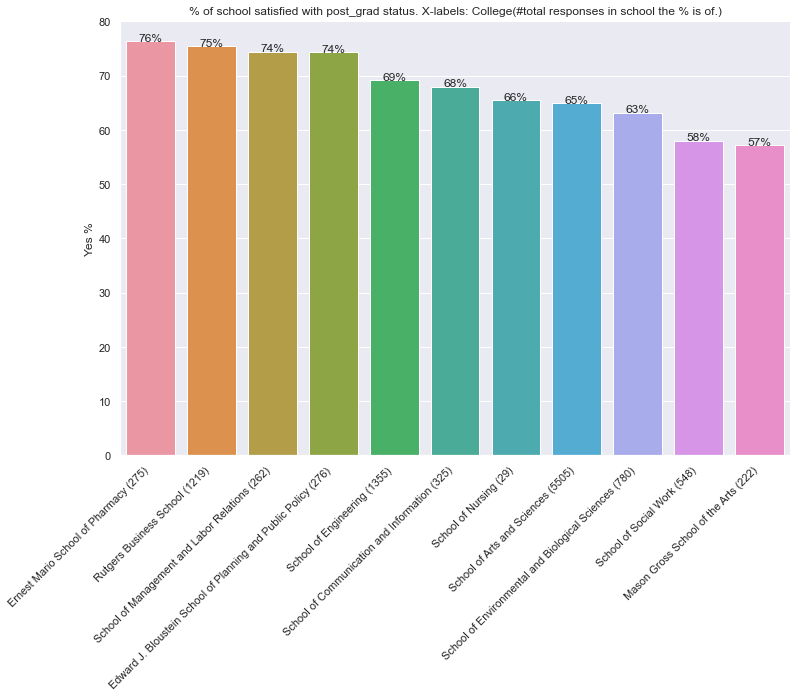

In [73]:
#Graph 22: Plot each college in Rutgers by % satisfied

results = pd.DataFrame(columns=['Yes %', 'No %'])

#Get % satsifaction by college
for school in df['school'].unique():
    df_group = df[df['school']==school]
    counts = df_group['post_grad_choice'].value_counts(normalize=True)
    if 'Yes' in counts and 'No' in counts:
        results.loc[school] = [counts['Yes']*100, counts['No']*100]

results=results.sort_values(by='Yes %',ascending=False)

results['Count'] = [f'({df[df["school"]==school].shape[0]})' for school in results.index]
tick_labels = [f'{school} {count}' for school, count in zip(results.index, results['Count'])]

# Plot
ax = sns.barplot(data=results, x=tick_labels, y='Yes %')
ax.set_xticklabels(tick_labels, rotation=45, ha='right')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01, f"{height:.0f}%", ha='center')

ax.set_title("% of school satisfied with post_grad status. X-labels: College(#total responses in school the % is of.)")


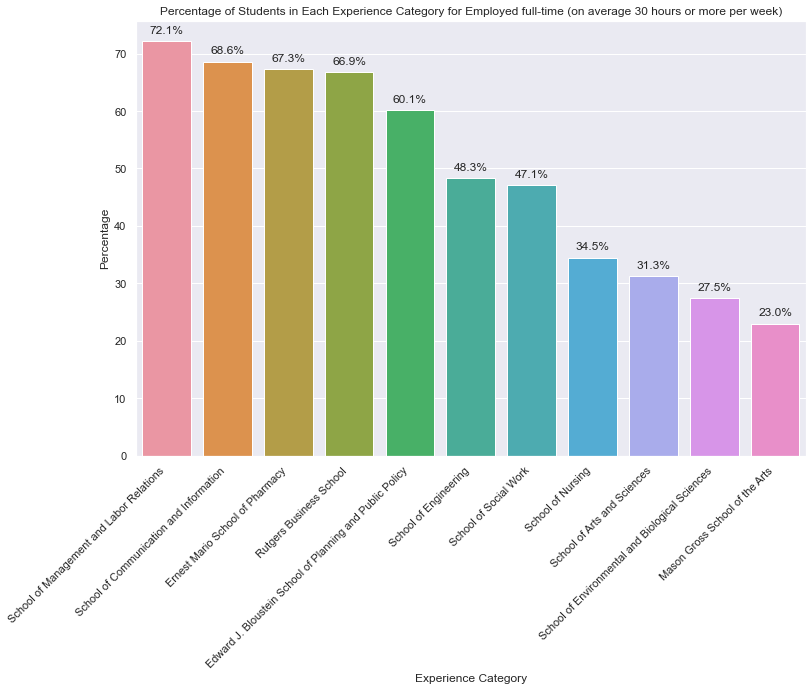

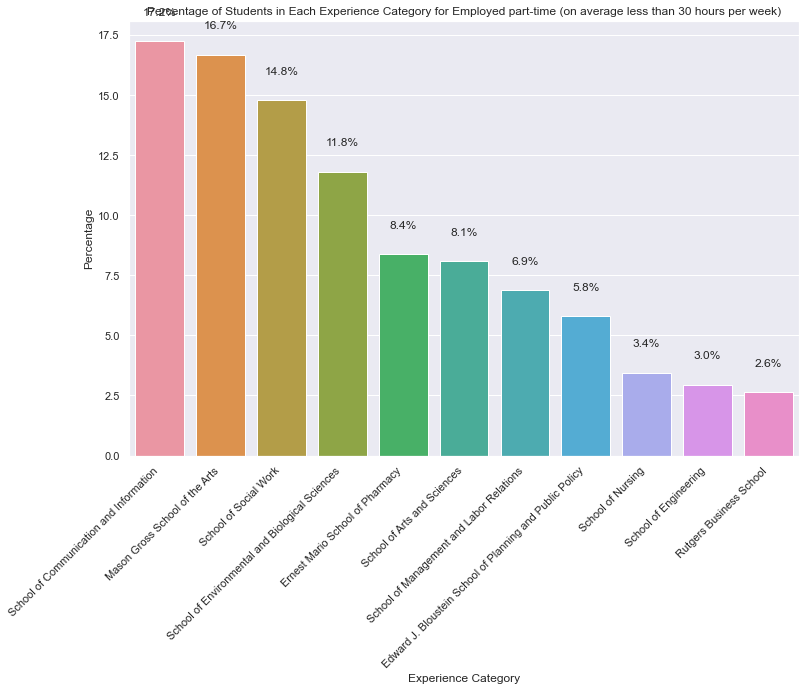

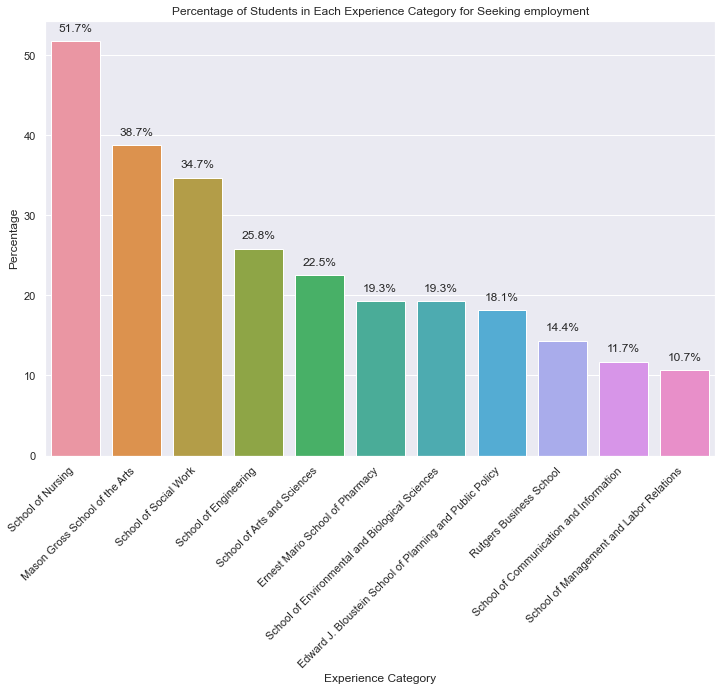

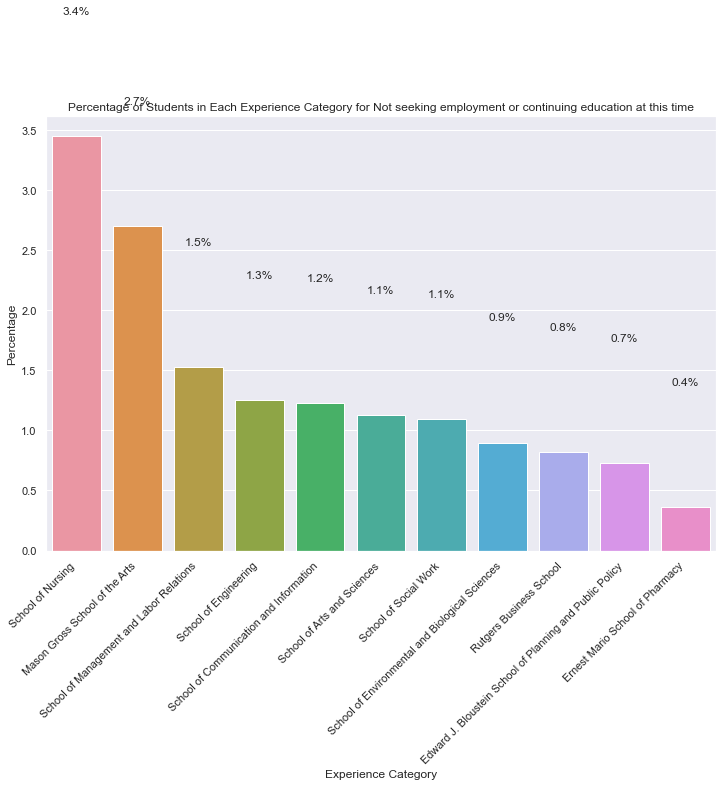

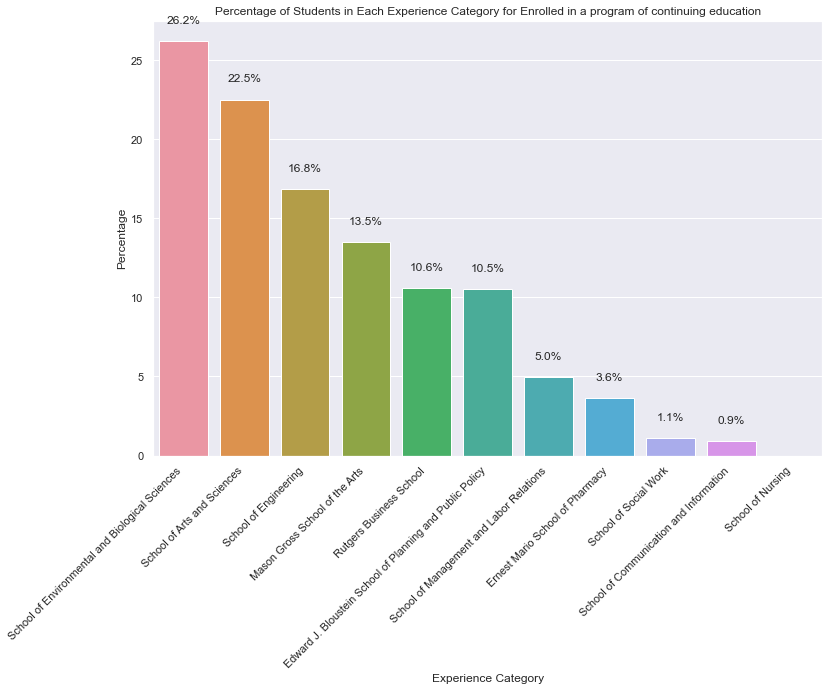

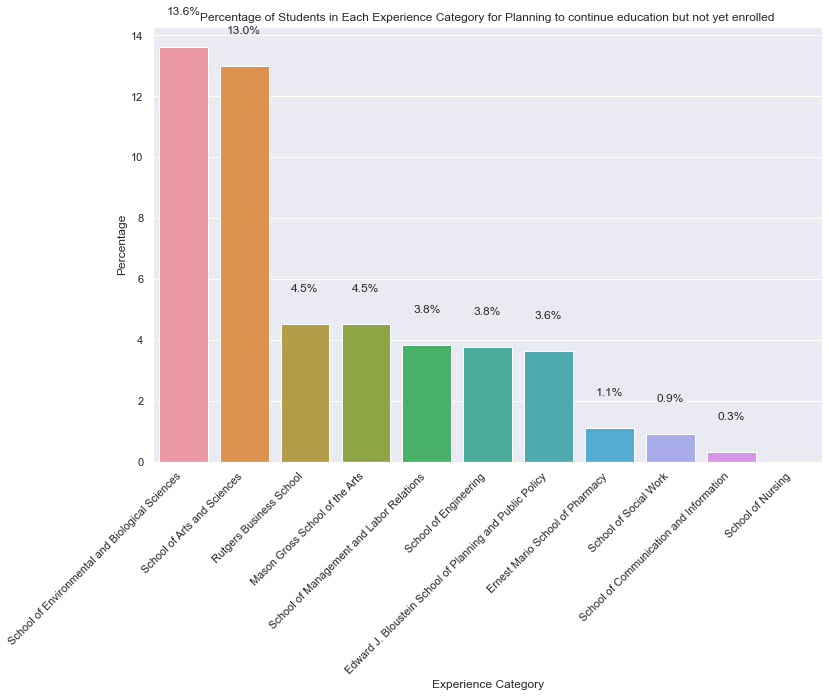

In [74]:
#Graphs 23-28: Showing each college and the % of people in that college in each status

results = pd.DataFrame(columns=df['school'].unique())

# Loop through each school and get % of students in each status
for school in df['school'].unique():
    df_school = df[df['school'] == school]
    counts = df_school['post_grad_status'].value_counts(normalize=True)
    results[school] = counts * 100

# Plot % for each college and experience category
for index, row in results.iterrows():
    plt.figure()
    row=row.sort_values(ascending=False)
    ax = sns.barplot(x=row.index, y=row.values)
    plt.xlabel('Experience Category')
    plt.ylabel('Percentage')
    plt.title('Percentage of Students in Each Experience Category for ' + index)
    ax.set_xticklabels(row.index, rotation=45, ha='right')
    for i, v in enumerate(row.values):
        if not np.isnan(v):
            ax.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
    plt.show()

#Uncomment below to see in table format
# results

In [75]:
#Table 29 A table of each experience and the post grad status counts along with 
#%seeking employment, fully employed, and ratio of want to be in further education.


df2 = df.copy()

# Define order of categories
status_order = [
    'Employed full-time (on average 30 hours or more per week)',
    'Seeking employment',
    'Enrolled in a program of continuing education',
    'Planning to continue education but not yet enrolled',
    'Employed part-time (on average less than 30 hours per week)',
    'Not seeking employment or continuing education at this time',
    'Serving in the U.S. military',
    'Participating in a volunteer or service program (e.g., Peace Corps)'
]

# Calculate the count of post_grad_status for each experience
status_count = []
for experience in df2['experiences'].explode().unique():
    
    # Filter data for the current experience
    experience_data = df2[df2['experiences'].apply(lambda x: experience in x)]
    
    # Calculate the count of post_grad_status
    count_df = experience_data.groupby('post_grad_status').size().reset_index(name='count')
    
    # Add the current experience to the overall DataFrame
    count_df['experience'] = experience
    status_count.append(count_df)

# Combine the list of DataFrames into a single DataFrame
status_count = pd.concat(status_count)

# Pivot the DataFrame to create the table
table = status_count.pivot(index='experience', columns='post_grad_status', values='count').fillna(0)
table = table.astype(int)
table = table.loc[df2['experiences'].explode().unique()]
table['% Seeking employment'] = 100 * (table['Seeking employment'] / table['Seeking employment'].sum(axis=0))/ table.sum(axis=1)
table['% Full-time employed'] = 100 * (table['Employed full-time (on average 30 hours or more per week)'] / table['Employed full-time (on average 30 hours or more per week)'].sum(axis=0))/ table.sum(axis=1)
table['% Enrolled : want to'] = 100 * (table['Enrolled in a program of continuing education'] / table['Enrolled in a program of continuing education'].sum(axis=0)) / table.sum(axis=1)


# You can investigate experiences by, for example, the 3 experiences that have 
#the highest % full time employed or ratio of being enrolled to wanting to be in further education. See below:

topEmp=table.sort_values(by='% Full-time employed',ascending=False).index[:3].to_list()
topGrad=table.sort_values(by='% Enrolled : want to',ascending=False).index[:3].to_list()
topSeek=table.sort_values(by='% Seeking employment',ascending=False).index[:3].to_list()

print("Top 3 experiences leading to highest % fully-employed:",topEmp)
print("Top 3 getting into grad school:",topGrad)
print("Top 3 experiences leading to highest % seeking employment:",topSeek)
table



Top 3 experiences leading to highest % fully-employed: ['Co-op', 'Case Competition', 'Internship']
Top 3 getting into grad school: ['Student Teaching', 'Research', 'ClinicalShadowing/Assistantship']
Top 3 experiences leading to highest % seeking employment: ['Field Placement', 'None', 'Study Abroad']


post_grad_status,Employed full-time (on average 30 hours or more per week),Employed part-time (on average less than 30 hours per week),Enrolled in a program of continuing education,Not seeking employment or continuing education at this time,"Participating in a volunteer or service program (e.g., Peace Corps)",Planning to continue education but not yet enrolled,Seeking employment,Serving in the U.S. military,% Seeking employment,% Full-time employed,% Enrolled : want to
experience,,,,,,,,,,,
Field Placement,350,101,254,12,10,81,276,1,0.004579,0.002894,0.004108
Internship,2726,361,908,40,26,409,1027,19,0.003352,0.004434,0.002888
ClinicalShadowing/Assistantship,267,75,239,9,6,175,116,5,0.002341,0.002686,0.004701
EmployedCampus/Parttime,2200,520,1019,38,27,513,1230,47,0.003958,0.003529,0.003196
None,636,118,145,39,2,96,339,10,0.004406,0.004120,0.001837
Student Org,1509,234,800,31,24,367,804,30,0.003810,0.003564,0.003695
Community Service,897,179,652,24,23,355,569,28,0.003756,0.002951,0.004195
Case Competition,312,8,60,4,1,18,61,0,0.002367,0.006033,0.002269
Research,502,85,511,8,10,190,289,9,0.003243,0.002808,0.005590


[Text(0, 0, 'Co-op'),
 Text(1, 0, 'Case Competition'),
 Text(2, 0, 'Internship'),
 Text(3, 0, 'None'),
 Text(4, 0, 'Mentorship Program'),
 Text(5, 0, 'Student Org'),
 Text(6, 0, 'EmployedCampus/Parttime'),
 Text(7, 0, 'Athletics'),
 Text(8, 0, 'RLC'),
 Text(9, 0, 'Community Service'),
 Text(10, 0, 'Field Placement'),
 Text(11, 0, 'Study Abroad'),
 Text(12, 0, 'Research'),
 Text(13, 0, 'ClinicalShadowing/Assistantship'),
 Text(14, 0, 'Student Teaching')]

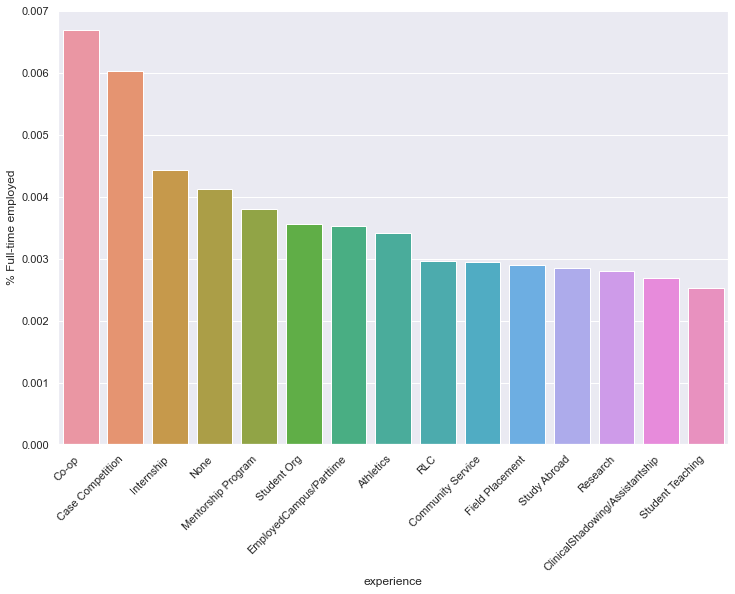

In [76]:
#Ex: Plotting a table sorting experiences by % who did that who are now fully employed

table=table.sort_values(by='% Full-time employed',ascending=False)

ax=sns.barplot(data=table, x=table.index, y='% Full-time employed')
ax.set_xticklabels(table.index,rotation=45, ha='right')



In [77]:
#Part 3: -----Models-----

In [78]:
#Splitting the data, keeping independent variables major, status, and experiences. Dependant variable post_grad_choice.

# Getting columns we're interested in using for the model
data = df[['post_grad_choice', 'major', 'post_grad_status', 'experiences']]

# Splitting the data into features (z) and target (p)
z = data.drop('post_grad_choice', axis=1)
p = data[['post_grad_choice']]
z_train, z_test, p_train, p_test = train_test_split(z, p, test_size=0.2, random_state=43, stratify=p)


#Experiences set up

# Perform one-hot encoding on the 'experiences' column
z_train['experiences'] = z_train['experiences'].apply(lambda x: ','.join(x))
z_test['experiences'] = z_test['experiences'].apply(lambda x: ','.join(x))

# Getting dummy variables since experiences is a list value
dummy_z_train = z_train['experiences'].str.get_dummies(sep=',')
dummy_z_test = z_test['experiences'].str.get_dummies(sep=',')

z_train = pd.concat([z_train, dummy_z_train], axis=1)
z_test = pd.concat([z_test, dummy_z_test], axis=1)


z_train = z_train.drop('experiences', axis=1)
z_test = z_test.drop('experiences', axis=1)

#Setting up other 2:
z_train = pd.get_dummies(z_train, columns=['post_grad_status', 'major'])
z_test = pd.get_dummies(z_test, columns=['post_grad_status', 'major'])


# Keeping consistent columns of major in training and testing data since might have majors with
# very small sample sizes such that they appear in training but not testing

missing_columns = set(z_train.columns) - set(z_test.columns)
for col in missing_columns:
    z_test[col] = 0

missing_columns = set(z_test.columns) - set(z_train.columns)
for col in missing_columns:
    z_train[col] = 0
    
z_test = z_test[z_train.columns]

#Saving the column indices so can make models using just those columns to predict satisfaction of post_grad_choice. 
exp = z_train.columns[:15]
status = z_train.columns[15:23]
majors = z_train.columns[23:]
expMajors= z_train.columns[:15].tolist() + z_train.columns[23:].tolist()

p_train= pd.get_dummies(p_train.post_grad_choice, drop_first=True)
p_test= pd.get_dummies(p_test.post_grad_choice, drop_first=True)


In [79]:
#Model 1: Status

# Initialize logistic regression model
logregstatus = LogisticRegression()

# Fit the model with training data for 'status' feature
logregstatus.fit(z_train[status], np.ravel(p_train))

# Predict the target variable 'post_grad_choice' for training data
p_pred_train = logregstatus.predict(z_train[status])

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict satisfaction for test data
p_pred = logregstatus.predict(z_test[status])

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)


# Count predicted labels for test
label_counts = Counter(p_pred)
print("Test prediction counts:", label_counts)

# Retrieve the coefficients from the trained logistic regression model
coefficients = logregstatus.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_status = pd.DataFrame({'Variable': z_train[status].columns, 'Coefficient': coefficients})

coefficients_status['Variable'] = coefficients_status['Variable'].str.replace('post_grad_status_', '', regex=True)

coefficients_status['CountInDf'] = coefficients_status['Variable'].apply(lambda x: df[df['post_grad_status'] == x].shape[0])

# Print out the dataframe of variables and their weights
coefficients_status.sort_values(by='Coefficient',ascending=False)


Training Accuracy: 0.7870541917554423
Test Accuracy: 0.7902777777777777
Test prediction counts: Counter({1: 1503, 0: 657})


,Variable,Coefficient,CountInDf
0,Employed full-time (on average 30 hours or more per week),1.050013,4488
2,Enrolled in a program of continuing education,1.020304,1891
7,Serving in the U.S. military,0.846185,73
4,"Participating in a volunteer or service program (e.g., Peace Corps)",0.571406,41
5,Planning to continue education but not yet enrolled,-0.179506,966
3,Not seeking employment or continuing education at this time,-0.403058,120
6,Seeking employment,-1.552813,2375
1,Employed part-time (on average less than 30 hours per week),-1.671433,841


In [80]:
#Model 2: Experiences

# Initialize logistic regression model - uncomment below to use unbalanced version that predicts all satisfied
# logregexp = LogisticRegression()
logregexp = LogisticRegression(class_weight='balanced')


# Fit the model with training data for 'experiences' feature
logregexp.fit(z_train[exp], np.ravel(p_train))

# Predict the target variable 'post_grad_choice' for training data
p_pred_train = logregexp.predict(z_train[exp])

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict the target variable 'post_grad_choice' for test data
p_pred = logregexp.predict(z_test[exp])

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)


# Test predictions:
label_counts = Counter(p_pred)
print("Test prediction counts:", label_counts)


# Retrieve the coefficients from the trained logistic regression model
coefficients = logregexp.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_exp = pd.DataFrame({'Variable': z_train[exp].columns, 'Coefficient': coefficients})


# Define a function to count occurrences of experiences in df
def count_exp_occurrences(exp):
    return df[df['experiences'].apply(lambda x: exp in x)].shape[0]

# Apply the function to get count of occurrences for each experience in df
coefficients_exp['CountInDf'] = coefficients_exp['Variable'].apply(count_exp_occurrences)


# Print out the dataframe of variables and their weights
coefficients_exp.sort_values(by='Coefficient',ascending=False)


Training Accuracy: 0.5306855025474757
Test Accuracy: 0.5273148148148148
Test prediction counts: Counter({0: 1213, 1: 947})


,Variable,Coefficient,CountInDf
3,Co-op,0.625906,377
1,Case Competition,0.401378,464
13,Student Teaching,0.377464,509
7,Internship,0.350668,5516
8,Mentorship Program,0.329999,978
2,ClinicalShadowing/Assistantship,0.317531,892
9,None,0.241103,1385
11,Research,0.237738,1605
0,Athletics,0.153740,1262
12,Student Org,0.081741,3799


In [81]:
#Model 3: Majors

# Initialize logistic regression model
logregmajors = LogisticRegression()

# Fit the model with training data for 'experiences' feature
logregmajors.fit(z_train[z_train.columns[23:]], np.ravel(p_train))

# Predict the target variable 'post_grad_choice' for training data
p_pred_train = logregmajors.predict(z_train[z_train.columns[23:]])

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict the target variable 'post_grad_choice' for test data
p_pred = logregmajors.predict(z_test[z_train.columns[23:]])

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)

# Count predicted labels for train
label_counts = Counter(p_pred_train)
print("Label counts train:", label_counts)

# Count predicted labels for test
label_counts = Counter(p_pred)
print("Label counts test:", label_counts)


# Retrieve the coefficients from the trained logistic regression model
coefficients = logregmajors.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_majors = pd.DataFrame({'Variable': z_train[z_train.columns[23:]].columns, 'Coefficient': coefficients})

# Print out the dataframe of variables and their weights
coefficients_majors.sort_values(by='Coefficient',ascending=False)

# Get the top 10 coefficient rows by absolute value
top_10_abs = coefficients_majors.iloc[np.abs(coefficients_majors['Coefficient']).argsort()[::-1][:10]].copy()

# Get the lowest 10 coefficient rows by absolute value
lowest_10_abs = coefficients_majors.iloc[np.abs(coefficients_majors['Coefficient']).argsort()[:10]].copy()

top_10_abs['Variable'] = top_10_abs['Variable'].str.replace('major_', '', regex=True)
lowest_10_abs['Variable'] = lowest_10_abs['Variable'].str.replace('major_', '', regex=True)

# Add a column to top_10_abs and lowest_10_abs with count of rows in df that have the major mentioned in "Variable" column
top_10_abs['CountInDf'] = top_10_abs['Variable'].apply(lambda x: df[df['major'] == x].shape[0])
lowest_10_abs['CountInDf'] = lowest_10_abs['Variable'].apply(lambda x: df[df['major'] == x].shape[0])


print("Top 10 Coefficient Rows by Absolute Value:")
top_10_abs.sort_values(by='Coefficient', ascending=False)


Training Accuracy: 0.6716072255673923
Test Accuracy: 0.6694444444444444
Label counts train: Counter({1: 8424, 0: 212})
Label counts test: Counter({1: 2118, 0: 42})
Top 10 Coefficient Rows by Absolute Value:


,Variable,Coefficient,CountInDf
130,Urban Planning and Policy Development,1.142269,28
60,Genetics,1.074276,65
99,Molecular Biology and Biochemistry,0.793872,14
111,"Planning, Urban",0.793320,22
28,Civil Engineering,0.791149,36
13,Bio-Mathematics,-0.730479,14
64,German,-0.802255,5
9,Art,-0.925980,12
4,American Studies,-0.925980,8
41,East Asian Languages and Studies,-1.167097,6


In [82]:
#Model 4: Majors & Experiences

# Initialize logistic regression model - uncomment to use the unbalanced version
# logregstatus = LogisticRegression()
logregstatus = LogisticRegression(class_weight='balanced')

# Fit the model with training data for 'status' feature
logregstatus.fit(z_train[expMajors], np.ravel(p_train))

# Predict the target variable 'post_grad_choice' for training data
p_pred_train = logregstatus.predict(z_train[expMajors])

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict the target variable 'post_grad_choice' for test data
p_pred = logregstatus.predict(z_test[expMajors])

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)


# Count predicted labels for training
label_counts = Counter(p_pred_train)
print("Label counts train:", label_counts)

# Count predicted labels for testing
label_counts = Counter(p_pred)
print("Label counts test:", label_counts)


# Retrieve the coefficients from the trained logistic regression model
coefficients = logregstatus.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_status = pd.DataFrame({'Variable': z_train[expMajors].columns, 'Coefficient': coefficients})

coefficients_status['Variable'] = coefficients_status['Variable'].str.replace('post_grad_status_', '', regex=True)

coefficients_status['CountInDf'] = coefficients_status['Variable'].apply(lambda x: df[df['post_grad_status'] == x].shape[0])
# Print out the dataframe of variables and their weights
coefficients_status.sort_values(by='Coefficient',ascending=False)


Training Accuracy: 0.5871931449745252
Test Accuracy: 0.5657407407407408
Label counts train: Counter({1: 4515, 0: 4121})
Label counts test: Counter({1: 1132, 0: 1028})


,Variable,Coefficient,CountInDf
145,major_Urban Planning and Policy Development,1.255342,0
75,major_Genetics,0.961330,0
126,"major_Planning, Urban",0.885482,0
114,major_Molecular Biology and Biochemistry,0.834510,0
43,major_Civil Engineering,0.805441,0
...,...,...,...
28,major_Bio-Mathematics,-0.766001,0
79,major_German,-0.781515,0
24,major_Art,-0.833200,0
19,major_American Studies,-1.008481,0


In [83]:
#Model 5: Status & Majors & Experiences
#Uncomment below to use unbalanced
# model = LogisticRegression()

model = LogisticRegression(class_weight='balanced')

# Fit the model to the training data
model.fit(z_train, np.ravel(p_train))

# Predict using the trained model on the test set
p_pred = model.predict(z_test)

print(classification_report(np.ravel(p_test), p_pred, target_names=['Unsatisfied','Satisfied']))


p_pred_train = model.predict(z_train)

accuracy_train = accuracy_score(np.ravel(p_train), p_pred_train)
print("Training Accuracy:", accuracy_train)

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)

#Print out vars and weights
namesAndCoeffs = pd.DataFrame()
variables = list(z_train.columns)
variables.insert(0,'Bias')
namesAndCoeffs['variables'] = variables
namesAndCoeffs['weights'] = np.insert(model.coef_, 0, model.intercept_)

#print("Predicting (1=Satisfied, 0=Unsatisfied): ",Counter(model.predict(z_test)))

# Retrieve the coefficients from the trained logistic regression model
coefficients = model.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_majors = pd.DataFrame({'Variable': z_train.columns, 'Coefficient': coefficients})

# Print out the dataframe of variables and their weights
coefficients_majors.sort_values(by='Coefficient',ascending=False)

              precision    recall  f1-score   support

 Unsatisfied       0.63      0.71      0.67       716
   Satisfied       0.85      0.79      0.82      1444

    accuracy                           0.77      2160
   macro avg       0.74      0.75      0.74      2160
weighted avg       0.77      0.77      0.77      2160

Training Accuracy: 0.7731588698471514
Test Accuracy: 0.7657407407407407


,Variable,Coefficient
15,post_grad_status_Employed full-time (on average 30 hours or more per week),1.041305
78,major_Environmental and business economics,1.012591
153,major_Urban Planning and Policy Development,1.004280
17,post_grad_status_Enrolled in a program of continuing education,1.003131
22,post_grad_status_Serving in the U.S. military,0.902623
...,...,...
37,major_Biochemistry,-0.877178
64,major_East Asian Languages and Studies,-0.883393
145,major_Spanish,-0.930041
21,post_grad_status_Seeking employment,-1.585912


In [84]:
#Make synthetic training data since the data is 2/3 satisfied, 1/3 not so it's being unbalanced.

# Instantiate the SMOTE algorithm
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
z_train_resampled, p_train_resampled = smote.fit_resample(z_train, p_train)

# Convert the resampled target variable back to a dataframe
p_train_resampled = pd.DataFrame(p_train_resampled, columns=p_train.columns)

# Print the shapes of the resampled data
print("Original Training Data Shape:", z_train.shape)
print("Original Training Data Class Distribution:", p_train['Yes'].value_counts())
print("Resampled Training Data Shape:", z_train_resampled.shape)
print("Resampled Training Data Class Distribution:", p_train_resampled['Yes'].value_counts())


Original Training Data Shape: (8636, 159)
Original Training Data Class Distribution: 1    5774
0    2862
Name: Yes, dtype: int64
Resampled Training Data Shape: (11548, 159)
Resampled Training Data Class Distribution: 0    5774
1    5774
Name: Yes, dtype: int64


In [85]:
#Model 1.2: Synthetic Status

# Initialize logistic regression model
logregstatus = LogisticRegression()

# Fit the model with training data for 'status' feature
logregstatus.fit(z_train_resampled[status], np.ravel(p_train_resampled))

# Predict the target variable 'post_grad_choice' for training data
p_pred_train = logregstatus.predict(z_train_resampled[status])

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train_resampled), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict the target variable 'post_grad_choice' for test data
p_pred = logregstatus.predict(z_test[status])

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)


# Count predicted labels for training
label_counts = Counter(p_pred_train)
print("Label counts train:", label_counts)

# Count predicted labels for testing
label_counts = Counter(p_pred)
print("Label counts test:", label_counts)

# Retrieve the coefficients from the trained logistic regression model
coefficients = logregstatus.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_status = pd.DataFrame({'Variable': z_train_resampled[status].columns, 'Coefficient': coefficients})

coefficients_status['Variable'] = coefficients_status['Variable'].str.replace('post_grad_status_', '', regex=True)

coefficients_status['CountInDf'] = coefficients_status['Variable'].apply(lambda x: df[df['post_grad_status'] == x].shape[0])

# Print out the dataframe of variables and their weights
coefficients_status.sort_values(by='Coefficient',ascending=False)


Training Accuracy: 0.7625562868029095
Test Accuracy: 0.7601851851851852
Label counts train: Counter({1: 5880, 0: 5668})
Label counts test: Counter({1: 1288, 0: 872})


,Variable,Coefficient,CountInDf
2,Enrolled in a program of continuing education,3.172992,1891
0,Employed full-time (on average 30 hours or more per week),3.116840,4488
7,Serving in the U.S. military,3.052544,73
4,"Participating in a volunteer or service program (e.g., Peace Corps)",2.816334,41
5,Planning to continue education but not yet enrolled,1.916774,966
3,Not seeking employment or continuing education at this time,1.827255,120
6,Seeking employment,0.481617,2375
1,Employed part-time (on average less than 30 hours per week),0.366630,841


In [86]:
#Model 2.2: Synthetic Experiences


# Initialize logistic regression model
logregexp = LogisticRegression()

# Fit the model with training data for 'experiences' feature
logregexp.fit(z_train_resampled[exp], np.ravel(p_train_resampled))

# Predict the target variable 'post_grad_choice' for training data
p_pred_train = logregexp.predict(z_train_resampled[exp])

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train_resampled), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict the target variable 'post_grad_choice' for test data
p_pred = logregexp.predict(z_test[exp])

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)

# Count predicted labels for training
label_counts = Counter(p_pred_train)
print("Label counts train:", label_counts)

# Count predicted labels for testing
label_counts = Counter(p_pred)
print("Label counts test:", label_counts)

# Retrieve the coefficients from the trained logistic regression model
coefficients = logregexp.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_exp = pd.DataFrame({'Variable': z_train_resampled[exp].columns, 'Coefficient': coefficients})


# Define a function to count occurrences of experiences in df
def count_exp_occurrences(exp):
    return df[df['experiences'].apply(lambda x: exp in x)].shape[0]

# Apply the function to get count of occurrences for each experience in df
coefficients_exp['CountInDf'] = coefficients_exp['Variable'].apply(count_exp_occurrences)


# Print out the dataframe of variables and their weights
coefficients_exp.sort_values(by='Coefficient',ascending=False)


Training Accuracy: 0.5831312781434015
Test Accuracy: 0.487962962962963
Label counts train: Counter({0: 8022, 1: 3526})
Label counts test: Counter({0: 1408, 1: 752})


,Variable,Coefficient,CountInDf
3,Co-op,1.120872,377
13,Student Teaching,0.728901,509
1,Case Competition,0.717537,464
8,Mentorship Program,0.608508,978
9,None,0.570284,1385
2,ClinicalShadowing/Assistantship,0.560985,892
7,Internship,0.465608,5516
10,RLC,0.399190,549
0,Athletics,0.394978,1262
11,Research,0.386330,1605


In [87]:
#Model 3.2: Synthetic Majors


# Initialize logistic regression model
logregmajors = LogisticRegression()

# Fit the model with training data for 'experiences' feature
logregmajors.fit(z_train_resampled[z_train_resampled.columns[23:]], np.ravel(p_train_resampled))

# Predict the target variable 'post_grad_choice' for training data
p_pred_train = logregmajors.predict(z_train_resampled[z_train_resampled.columns[23:]])

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train_resampled), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict the target variable 'post_grad_choice' for test data
p_pred = logregmajors.predict(z_test[z_train_resampled.columns[23:]])

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)


# Count predicted labels for training
label_counts = Counter(p_pred_train)
print("Label counts train:", label_counts)

# Count predicted labels for testing
label_counts = Counter(p_pred)
print("Label counts test:", label_counts)


# Retrieve the coefficients from the trained logistic regression model
coefficients = logregmajors.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_majors = pd.DataFrame({'Variable': z_train_resampled[z_train_resampled.columns[23:]].columns, 'Coefficient': coefficients})

# Print out the dataframe of variables and their weights
coefficients_majors.sort_values(by='Coefficient',ascending=False)

# Get the top 10 coefficient rows by absolute value
top_10_abs = coefficients_majors.iloc[np.abs(coefficients_majors['Coefficient']).argsort()[::-1][:10]].copy()

# Get the lowest 10 coefficient rows by absolute value
lowest_10_abs = coefficients_majors.iloc[np.abs(coefficients_majors['Coefficient']).argsort()[:10]].copy()

top_10_abs['Variable'] = top_10_abs['Variable'].str.replace('major_', '', regex=True)
lowest_10_abs['Variable'] = lowest_10_abs['Variable'].str.replace('major_', '', regex=True)

# Add a column to top_10_abs and lowest_10_abs with count of rows in df that have the major mentioned in "Variable" column
top_10_abs['CountInDf'] = top_10_abs['Variable'].apply(lambda x: df[df['major'] == x].shape[0])
lowest_10_abs['CountInDf'] = lowest_10_abs['Variable'].apply(lambda x: df[df['major'] == x].shape[0])


print("Top 10 Coefficient Rows by Absolute Value:")
top_10_abs

#Can uncomment below to see the smallest by absolute value

# print("\nLowest 10 Coefficient Rows by Absolute Value:")
# lowest_10_abs[np.abs(lowest_10_abs['Coefficient'])>0.001]


Training Accuracy: 0.6279875303082785
Test Accuracy: 0.6092592592592593
Label counts train: Counter({1: 7060, 0: 4488})
Label counts test: Counter({1: 1492, 0: 668})
Top 10 Coefficient Rows by Absolute Value:


,Variable,Coefficient,CountInDf
130,Urban Planning and Policy Development,2.793600,28
60,Genetics,2.750158,65
19,Business Analytics and Information Technology,2.536149,178
28,Civil Engineering,2.504211,36
111,"Planning, Urban",2.478975,22
106,Pharmacy,2.408536,188
29,Civil and Environmental Engineering,2.377055,77
21,Cell Biology and Neuroscience,2.373558,118
125,Statistics - Mathematics,2.283444,21
100,Molecular Biology and Biochemistry,2.279406,29


In [88]:
#Model 4.2: Synthetic Majors & Experiences


# Initialize logistic regression model
logregexp = LogisticRegression(max_iter=1000)

# Fit the model with training data for 'experiences' feature
logregexp.fit(z_train_resampled[expMajors], np.ravel(p_train_resampled))

# Predict the target variable 'post_grad_choice' for training data
p_pred_train = logregexp.predict(z_train_resampled[expMajors])

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train_resampled), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict the target variable 'post_grad_choice' for test data
p_pred = logregexp.predict(z_test[expMajors])

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)

# Count predicted labels for training
label_counts = Counter(p_pred_train)
# print("Label counts train:", label_counts)

# Count predicted labels for testing
label_counts = Counter(p_pred)
print("Label counts test:", label_counts)

# Generate classification report for test data
report = classification_report(np.ravel(p_test), p_pred)
print(report)

# Retrieve the coefficients from the trained logistic regression model
coefficients = logregexp.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_exp = pd.DataFrame({'Variable': z_train_resampled[expMajors].columns, 'Coefficient': coefficients})


# # Define a function to count occurrences of experiences in df
# def count_exp_occurrences(exp):
#     return df[df['experiences'].apply(lambda x: exp in x)].shape[0]

# # Apply the function to get count of occurrences for each experience in df
# coefficients_exp['CountInDf'] = coefficients_exp['Variable'].apply(count_exp_occurrences)


# # Print out the dataframe of variables and their weights
coefficients_exp.sort_values(by='Coefficient',ascending=False)



Training Accuracy: 0.6559577416002771
Test Accuracy: 0.612037037037037
Label counts test: Counter({1: 1396, 0: 764})
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       716
           1       0.72      0.69      0.70      1444

    accuracy                           0.61      2160
   macro avg       0.57      0.57      0.57      2160
weighted avg       0.62      0.61      0.62      2160



,Variable,Coefficient
145,major_Urban Planning and Policy Development,2.861735
126,"major_Planning, Urban",2.607944
43,major_Civil Engineering,2.575608
140,major_Statistics - Mathematics,2.371123
75,major_Genetics,2.366561
...,...,...
134,major_Russian,-0.133940
117,"major_Music (Composition, Musicology)",-0.179997
61,major_Electrical and Computer Engineering (Dual Degree Undergrad Program),-0.183213
56,major_East Asian Languages and Studies,-0.185019


In [89]:
#Model 5.2: Synthetic Status & Majors & Experiences

model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
model.fit(z_train_resampled, np.ravel(p_train_resampled))

# Predict the target variable 'post_grad_choice' for test data
p_pred_train = model.predict(z_train_resampled)

# Calculate accuracy of the model on training data
accuracy_train = accuracy_score(np.ravel(p_train_resampled), p_pred_train)
print("Training Accuracy:", accuracy_train)


# Predict the target variable 'post_grad_choice' for test data
p_pred = model.predict(z_test)

# Calculate accuracy of the model on test data
accuracy_test = accuracy_score(np.ravel(p_test), p_pred)
print("Test Accuracy:", accuracy_test)


# Predict using the trained model on the test set

print(classification_report(np.ravel(p_test), p_pred, target_names=['Unsatisfied','Satisfied']))

#Print out vars and weights
namesAndCoeffs = pd.DataFrame()
variables = list(z_train_resampled.columns)
variables.insert(0,'Bias')
namesAndCoeffs['variables'] = variables
namesAndCoeffs['weights'] = np.insert(model.coef_, 0, model.intercept_)

print(Counter(model.predict(z_test)))

# Calculate accuracy of the model on training data



# Retrieve the coefficients from the trained logistic regression model
coefficients = model.coef_[0]

# Create a dataframe to store the coefficients along with their corresponding variable names
coefficients_majors = pd.DataFrame({'Variable': z_train_resampled.columns, 'Coefficient': coefficients})

# Print out the dataframe of variables and their weights
coefficients_majors.sort_values(by='Coefficient',ascending=False)

Training Accuracy: 0.8028229996536197
Test Accuracy: 0.774537037037037
              precision    recall  f1-score   support

 Unsatisfied       0.65      0.69      0.67       716
   Satisfied       0.84      0.82      0.83      1444

    accuracy                           0.77      2160
   macro avg       0.75      0.75      0.75      2160
weighted avg       0.78      0.77      0.78      2160

Counter({1: 1401, 0: 759})


,Variable,Coefficient
15,post_grad_status_Employed full-time (on average 30 hours or more per week),3.151405
17,post_grad_status_Enrolled in a program of continuing education,3.147603
22,post_grad_status_Serving in the U.S. military,3.021922
153,major_Urban Planning and Policy Development,2.532314
19,"post_grad_status_Participating in a volunteer or service program (e.g., Peace Corps)",2.462803
...,...,...
142,major_Russian,-0.040551
69,major_Electrical and Computer Engineering (Dual Degree Undergrad Program),-0.067020
82,major_French,-0.082094
64,major_East Asian Languages and Studies,-0.108832


Training accuracy:  79.18017600741084 % . Testing accuracy:  78.51851851851852 %
              precision    recall  f1-score   support

   Satisfied       0.70      0.63      0.66       716
 Unsatisfied       0.82      0.86      0.84      1444

    accuracy                           0.79      2160
   macro avg       0.76      0.75      0.75      2160
weighted avg       0.78      0.79      0.78      2160



Counter({0: 646, 1: 1514})

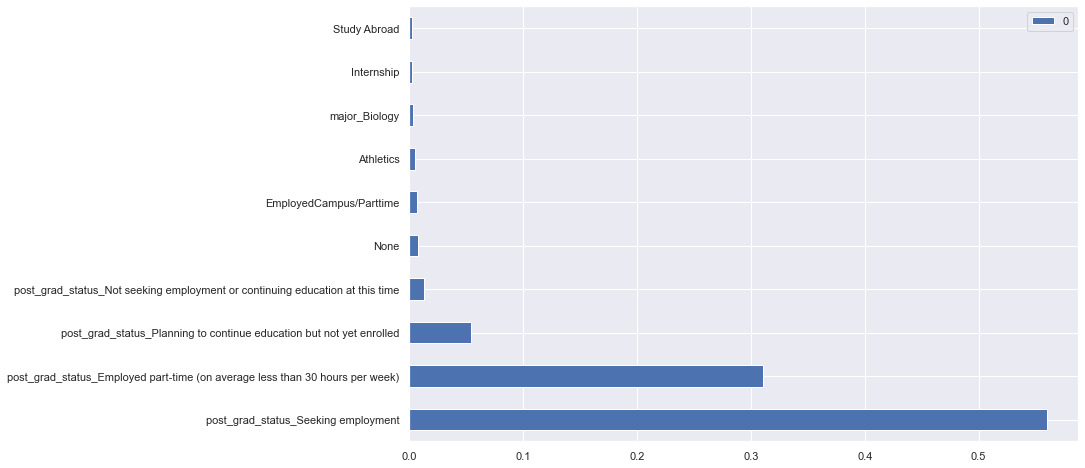

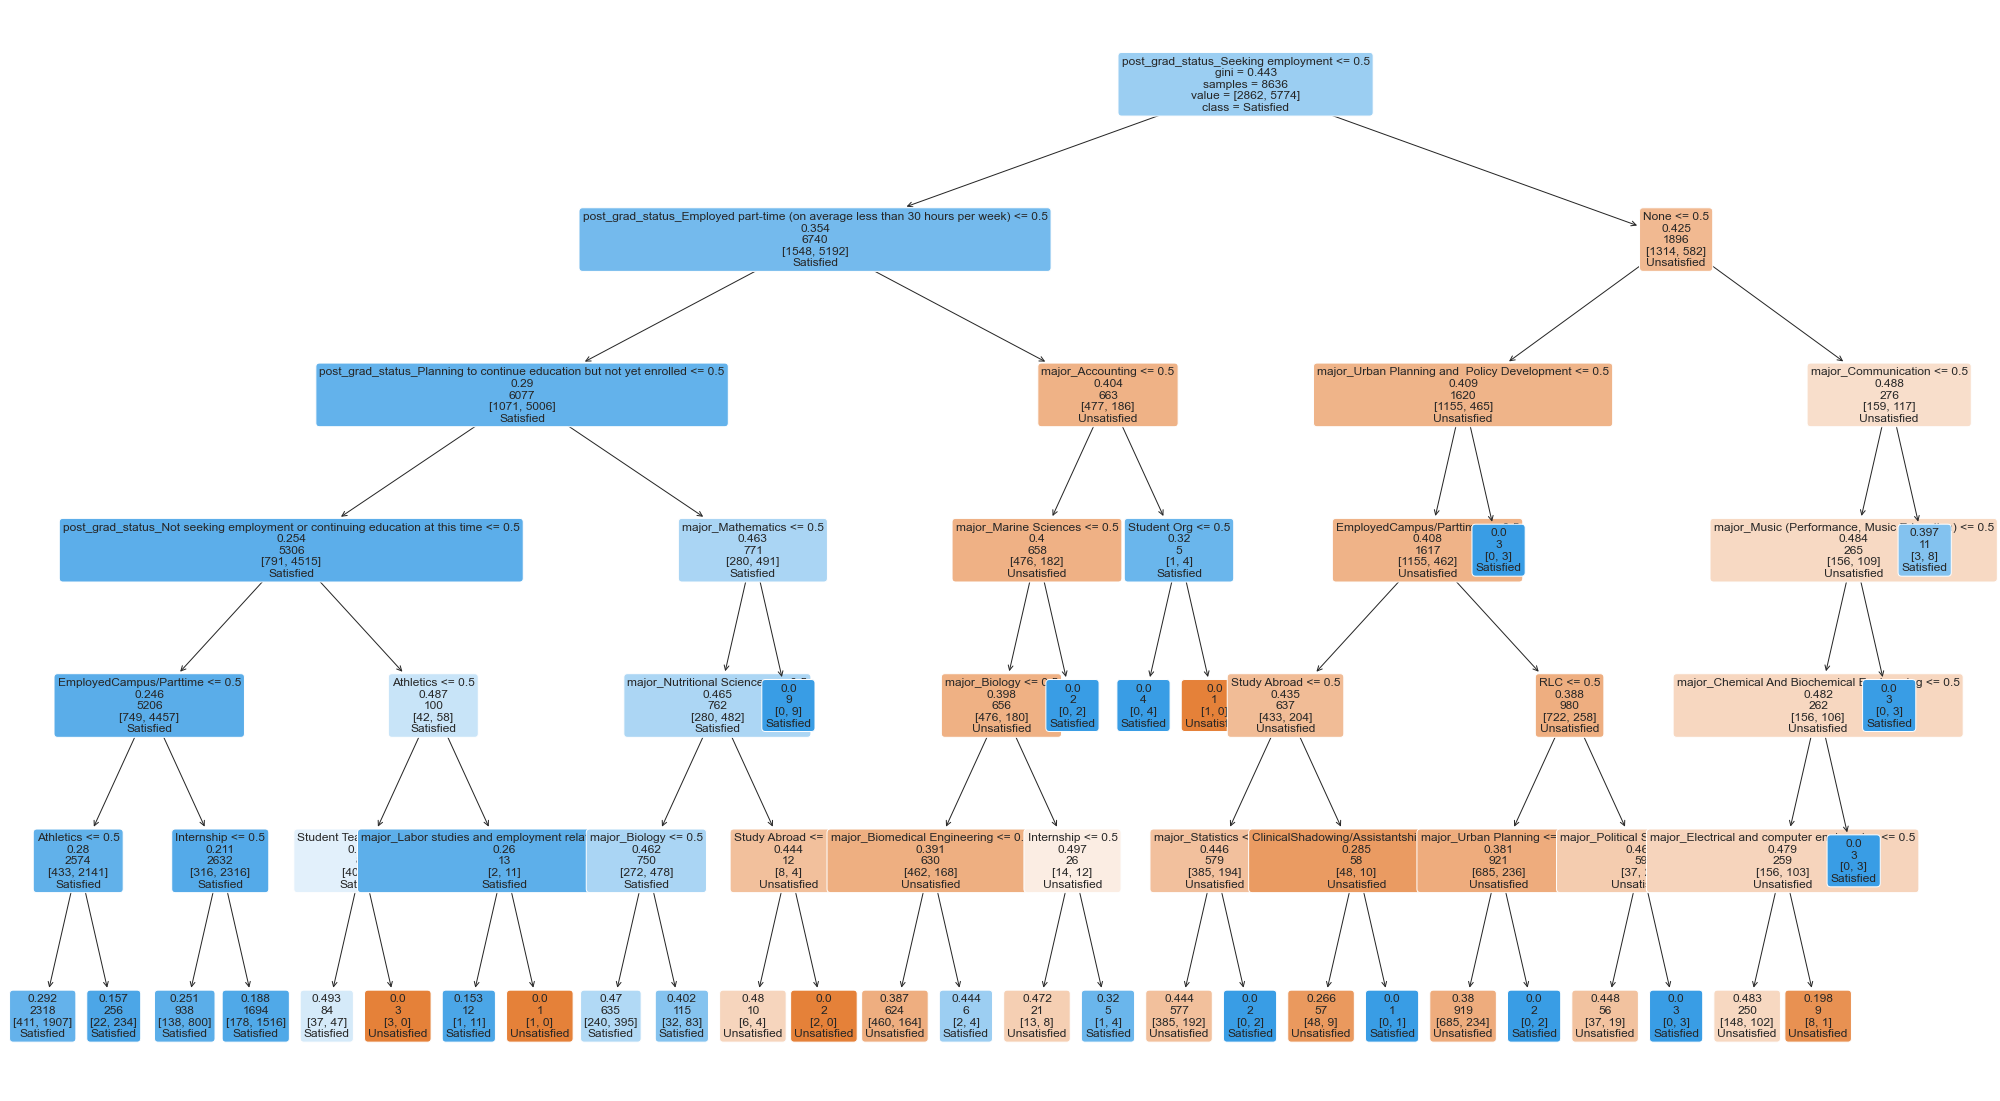

In [90]:
#Model 6: Decision Tree

ccp_alpha = 0.00000001
max_depth=6
criterion='entropy'
clf = DecisionTreeClassifier(max_depth=max_depth, ccp_alpha=ccp_alpha)
clf = clf.fit(z_train,np.ravel(p_train))

feature_names = z_train.columns
feature_importance = pd.DataFrame(clf.feature_importances_,index=feature_names).sort_values(by=0,ascending=False)
feature_importance

features = list(feature_importance[feature_importance[0]>0].index)
feature_importance.head(10).plot(kind='barh')

trainingPrediction = clf.predict(z_train)
predictions = clf.predict(z_test)

print("Training accuracy: ", 100*accuracy_score(np.ravel(p_train),trainingPrediction),"%",". Testing accuracy: ",100*accuracy_score(np.ravel(p_test),predictions),"%")
print(classification_report(np.ravel(p_test),predictions,target_names=['Satisfied','Unsatisfied']))

fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(clf,
                  feature_names=feature_names,
                  class_names={0:'Unsatisfied',1:'Satisfied'},
                label='root',
                  filled=True,
                   rounded=True,
                  fontsize=12)

Counter(clf.predict(z_test))

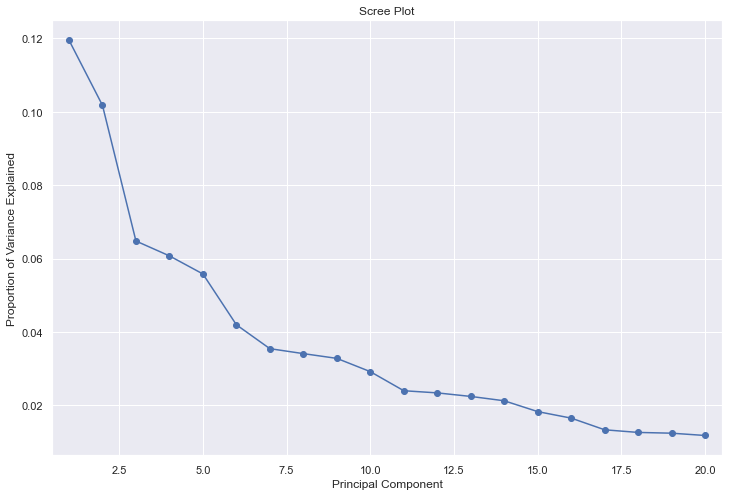

In [91]:
#Model 7: PCA: The following scree plot shows that 6 is a good amount of PCs to use 
#before the variance proportion levels off.

pca = PCA()
pca.fit(z_train)

plt.plot(range(1, 21), pca.explained_variance_ratio_[:20], 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.xlim(0.5, 20.5)
plt.show()


In [92]:
#Finding the principal components using 6 components

# extract x_train and y_train variables
X_train = z_train
y_train = p_train

# perform PCA with 6 components on training data
pca = PCA(n_components=6)
principal_components_train = pca.fit_transform(X_train)

# create a new dataframe with the principal components
df_pca_train = pd.DataFrame(data=principal_components_train, columns=['PC1', 'PC2', 'PC3','PC4','PC5','PC6'])

# interpret the principal components as linear combinations of the original variables
component_loadings = pd.DataFrame(pca.components_, columns=X_train.columns, index=['PC1', 'PC2', 'PC3','PC4','PC5','PC6'])

#Uncomment below 2 lines to see components loadings
# print("Component loadings:")
# print(component_loadings)




#Using a loading threshold of 0.4 find important columns:

# Set the loading threshold
loading_threshold = 0.4

# Find columns with a loading greater than the threshold on any of the principal components
important_cols = []
for col in component_loadings.columns:
    if (abs(component_loadings.loc['PC1', col]) > loading_threshold or
        abs(component_loadings.loc['PC2', col]) > loading_threshold or
        abs(component_loadings.loc['PC3', col]) > loading_threshold or
        abs(component_loadings.loc['PC4', col]) > loading_threshold or
        abs(component_loadings.loc['PC5', col]) > loading_threshold or
        abs(component_loadings.loc['PC6', col]) > loading_threshold):
        important_cols.append(col)

# Print the important columns
print("Important columns:")
print(important_cols)


#Re-run a balanced logistic regression on those 5 variables  (Before gave 54%, now 51% or so)

z_train_subset = z_train.loc[:, important_cols]
z_test_subset = z_test.loc[:, important_cols]


model = LogisticRegression(class_weight='balanced')

# Fit the model to the training data
model.fit(z_train_subset, np.ravel(p_train))

# Predict using the trained model on the test set
p_pred = model.predict(z_test_subset)

print(classification_report(np.ravel(p_test), p_pred, target_names=['Unsatisfied','Satisfied']))

# print(model.score(z_test, p_test))
#model.intercept_, model.coef_
test_accuracy = accuracy_score(p_test, p_pred)
print("Test accuracy:", test_accuracy)

#Print out vars and weights
namesAndCoeffs = pd.DataFrame()
variables = list(z_train_subset.columns)
variables.insert(0,'Bias')
namesAndCoeffs['variables'] = variables
namesAndCoeffs['weights'] = np.insert(model.coef_, 0, model.intercept_)

print(Counter(model.predict(z_test_subset)))

component_loadings


Important columns:
['Community Service', 'EmployedCampus/Parttime', 'Internship', 'Student Org', 'post_grad_status_Employed full-time (on average 30 hours or more per week)', 'post_grad_status_Enrolled in a program of continuing education', 'post_grad_status_Seeking employment']
              precision    recall  f1-score   support

 Unsatisfied       0.60      0.76      0.67       716
   Satisfied       0.86      0.75      0.80      1444

    accuracy                           0.75      2160
   macro avg       0.73      0.75      0.74      2160
weighted avg       0.78      0.75      0.76      2160

Test accuracy: 0.7541666666666667
Counter({1: 1263, 0: 897})


,Athletics,Case Competition,ClinicalShadowing/Assistantship,Co-op,Community Service,EmployedCampus/Parttime,Field Placement,Internship,Mentorship Program,None,...,major_Supply Chain And Marketing Science,major_Theater,major_Theater Arts,major_Urban Planning,major_Urban Planning and Policy Development,major_Visual Arts,major_Women's and Gender Studies,major_Agriculture And Food Systems,major_Mechanical Engineering - Dual Degree Program,major_Medieval Studies
PC1,0.099907,0.045204,0.071614,0.014134,0.392540,0.501335,-0.020671,0.372217,0.118615,-0.341885,...,0.004215,0.000501,-0.002188,0.000019,-0.002228,-0.000362,-0.000133,0.0,0.0,0.0
PC2,0.015208,-0.045885,0.051606,-0.051383,0.115237,0.022559,0.037793,-0.418194,-0.017650,0.052442,...,-0.033471,0.000214,0.001175,-0.000078,-0.002636,0.003021,0.000967,0.0,0.0,0.0
PC3,0.043457,0.013051,0.093758,-0.007480,0.261111,-0.294274,-0.081923,-0.488490,0.028865,0.160545,...,-0.005902,0.000276,-0.001283,-0.000875,0.000192,-0.002669,0.000525,0.0,0.0,0.0
PC4,0.036167,0.013340,-0.011613,0.001595,0.064241,-0.712915,0.088371,0.568732,0.027110,-0.036455,...,-0.001355,-0.000100,-0.001857,-0.001437,-0.001323,-0.001742,0.000334,-0.0,-0.0,-0.0
PC5,0.071403,0.027906,-0.088017,0.015624,0.142238,-0.271901,-0.093566,-0.085097,-0.033095,0.089484,...,0.010161,0.000716,0.000671,-0.002083,-0.000108,0.002014,0.001777,-0.0,-0.0,-0.0
PC6,-0.068001,-0.001277,0.181820,-0.020631,0.776541,-0.087035,0.141844,-0.003553,0.079608,0.017347,...,-0.000574,-0.001332,-0.000364,-0.000724,0.001837,-0.000756,0.000069,0.0,0.0,0.0


In [93]:
#Part 4: -----Appendix1-----

In [94]:
#Helper function that gives a list of majors and their satisfaction rates.
def satisfactionRates(threshold):
        satisfactionRates = {}
        for major_name in df['major'].unique():
            response_count = df[df['major'] == major_name]['post_grad_choice'].count()
            if response_count >= threshold:
                satisfaction_rate = df[df['major'] == major_name]['post_grad_choice'].value_counts(normalize=True) * 100
                yes_percent = satisfaction_rate['Yes'] if 'Yes' in satisfaction_rate else 0
                no_percent = satisfaction_rate['No'] if 'No' in satisfaction_rate else 0
                satisfactionRates[major_name] = {'Yes': yes_percent, 'No': no_percent}

        sorted_majors = sorted(satisfactionRates.keys(), key=lambda x: satisfactionRates[x]['Yes'], reverse=True)
        return sorted_majors, satisfactionRates

def satisfaction(major, minResponses):
    sorted_Majors, rates = satisfactionRates(minResponses)
    rank = sorted_Majors.index(major) + 1 if major in sorted_Majors else None
    if major in sorted_Majors:
        print(f'{major} is rank {rank} with {round(rates[major]["Yes"], 1)}% satisfied, {round(rates[major]["No"], 1)}% unsatisfied.')
    else:
        print(f"{major} didn't have over the minimum number of responses {minResponses} given. They have only: ",df[df['major']==major].shape[0])

def getMajorByRank(rank, minResponses):
    sorted_Majors,rates = satisfactionRates(minResponses)
    if(rank-1>=0 & rank-1 <= len(sorted_Majors)-1):
        print(sorted_Majors[rank-1])
    else:
        print('Rank number given is invalid')

    
# Example usage - passing in the major name or rank we want and the threshold of responses in that major we have data on
satisfaction('Genetics', 50)
getMajorByRank(1,50)


Genetics is rank 1 with 83.1% satisfied, 16.9% unsatisfied.
Genetics


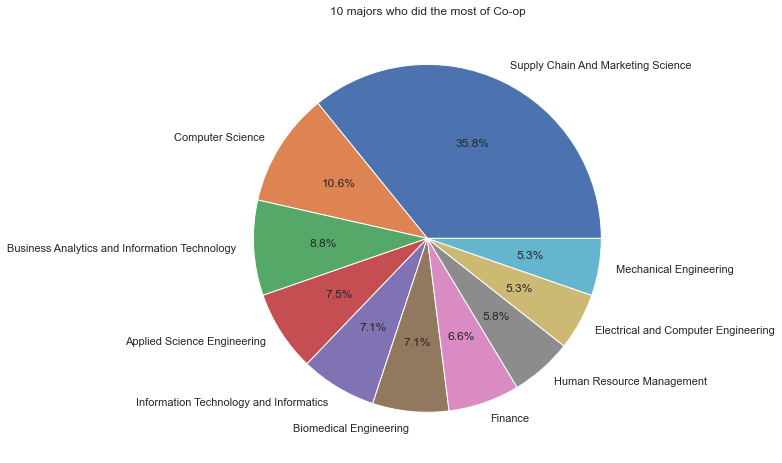

In [95]:
#Helper 2: Pick an experience. Find the 10 majors who did it the most.
#Ex: Co-op. To remind yourself of which experiences you can choose, use df['experiences'].explode().unique()

def topMajorsDoingExperience(experience):
    a = df[df['experiences'].apply(lambda x: experience in x)]['major'].value_counts(normalize=True)[:10].to_frame()
    counts = a['major'].values * 100
    labels = a.index.values

    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title(f'10 majors who did the most of {experience}')
    plt.show()

topMajorsDoingExperience('Co-op')

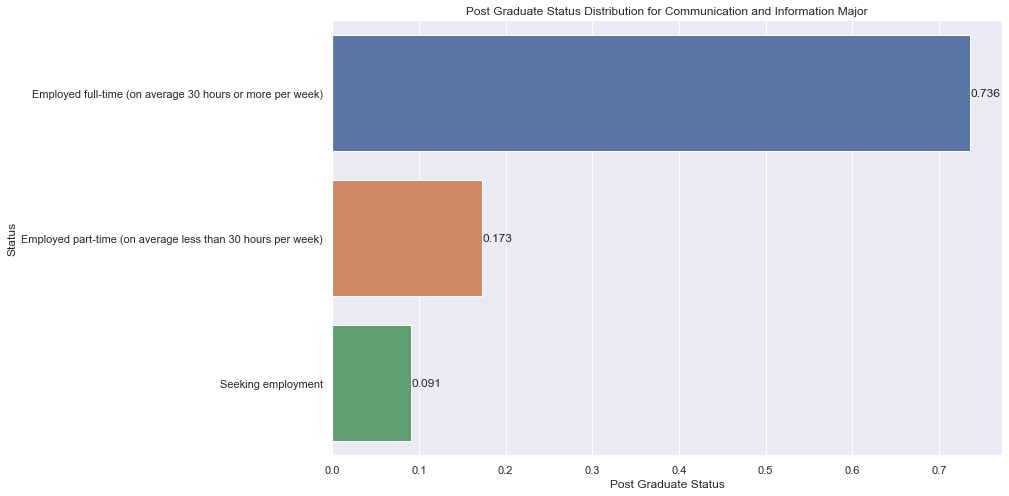

In [96]:
#Helper 3: Pick a major. Find the % post_grad_status breakdown.
#Ex: Communication and Information

def statusBreakdown(major):
    # Filter the data
    major_df = df[df['major'] == major ]

    # Count the values for the 'post_grad_status' column
    value_counts = major_df['post_grad_status'].value_counts(normalize=True).round(3)

    # Create a bar plot using seaborn
    ax = sns.barplot(x=value_counts.values, y=value_counts.index)

    # Rotate x-ticks for better visibility
    ax.set_yticks(range(len(value_counts.index)))

    # Add labels and title to the plot
    ax.set_xlabel('Post Graduate Status')
    ax.set_ylabel('Status')
    ax.set_title(f'Post Graduate Status Distribution for {major} Major')
    for bar in ax.containers:
        for rect in bar.patches:
            count = rect.get_width()
            ax.text(count, rect.get_y() + rect.get_height() / 2, count, ha='left', va='center')
    # Display the plot
    plt.show()


statusBreakdown('Communication and Information')

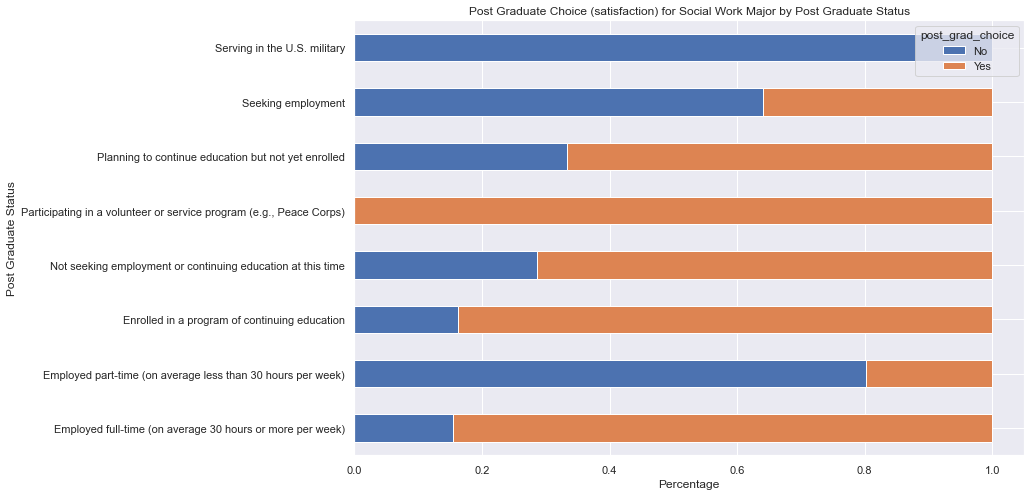

In [97]:
#Helper 4: Pick a major. Find how satisfied those from that major were in different statuses.
#Ex: For Social Work shows the breakdown of status by % in that status satisfied, 
#and that those who are unemployed and employed part-time are the most % unsatisfied of any status.

def statusSatisfactionBreakdown(major):
    major_df = df[df['major'] == major]

    # Group the data by post_grad_status and post_grad_choice, and calculate the percentage of each group
    grouped_df = major_df.groupby(['post_grad_status', 'post_grad_choice']).size().unstack().fillna(0)
    grouped_df['total'] = grouped_df.sum(axis=1)
    grouped_df = grouped_df.apply(lambda x: x / x['total'], axis=1)
    grouped_df = grouped_df.drop(columns=['total'])

    # Create a stacked bar plot using seaborn
    ax = grouped_df.plot(kind='barh', stacked=True)

    # Add labels and title to the plot
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Post Graduate Status')
    ax.set_title(f'Post Graduate Choice (satisfaction) for {major} Major by Post Graduate Status')

    # Display the plot
    plt.show()

statusSatisfactionBreakdown('Social Work')


In [98]:
#Helper 5: Pick a major. Shows a table of what status those in that major who did each experience are in.

#Ex: For social work majors, makes a table with rows being experiences and columns being statuses, and shows
#how many social work majors did each experience and of those how many fell into the statuses.

def experienceStatusTableForMajor(major):
    social_work_df = df[df['major'] == major][['experiences', 'post_grad_choice','post_grad_status']].explode('experiences')

    # Count the number of each post grad status for each experience
    counts = social_work_df.groupby(['experiences', 'post_grad_status']).size().unstack()

    # Add the count of each row to the index
    counts.index = [f'{exp} ({counts.loc[exp].sum()})' for exp in counts.index]

    # Display the counts in a table
    return counts


    #Uncomment below to show the table using percents
    # # Normalize each row to a percentage
    # counts = counts.div(counts.sum(axis=1), axis=0).multiply(100).round(2)

    # # Add percent symbol to each cell
    # counts = counts.astype(str) + '%'


    # # Display the normalized counts in a table
    # return counts

    
experienceStatusTableForMajor('Social Work')


post_grad_status,Employed full-time (on average 30 hours or more per week),Employed part-time (on average less than 30 hours per week),Enrolled in a program of continuing education,Not seeking employment or continuing education at this time,"Participating in a volunteer or service program (e.g., Peace Corps)",Planning to continue education but not yet enrolled,Seeking employment,Serving in the U.S. military
Athletics (5.0),NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN
ClinicalShadowing/Assistantship (22.0),7.0,3.0,3.0,1.0,NaN,NaN,8.0,NaN
Co-op (5.0),3.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN
Community Service (77.0),24.0,8.0,14.0,2.0,1.0,3.0,25.0,NaN
EmployedCampus/Parttime (219.0),70.0,38.0,38.0,3.0,2.0,5.0,63.0,NaN
Field Placement (505.0),191.0,65.0,59.0,6.0,2.0,8.0,174.0,NaN
Internship (327.0),121.0,41.0,40.0,3.0,NaN,5.0,116.0,1.0
Mentorship Program (11.0),1.0,NaN,5.0,NaN,NaN,1.0,4.0,NaN
None (29.0),23.0,3.0,1.0,NaN,NaN,NaN,2.0,NaN
RLC (9.0),3.0,1.0,3.0,NaN,NaN,NaN,2.0,NaN


In [99]:
#Intro to helper 6
#Investigating graph 8 as to why Field Placements aren't more effective to satisfaction than doing no experience.

experience = 'Field Placement'
#Take rows where they did a field placement
filtered_df = df[df['experiences'].apply(lambda x: experience in x)]

#Get the amount of each major who have done field placements
major_counts = filtered_df['major'].value_counts()

#Get the amount of those majors who are satisfied
satisfied_counts = filtered_df[filtered_df['post_grad_choice'] == 'Yes']['major'].value_counts()

count_data = {'Major': [], 'Count': [], 'Percentage_satisfied': []}

#For each major, put in the major, # who did the experience, and % satisfied who did that exp from that major.
for major, count in major_counts.iteritems():
    #Put in major name
    count_data['Major'].append(major)
    #Put in # of that major who did the experience
    count_data['Count'].append(count)
    
    #If there is a satisfied member of the major who did the experience, get % of the major who are satisfied
    if major in satisfied_counts:
        percentage = (satisfied_counts[major] / count) * 100
        count_data['Percentage_satisfied'].append(percentage)
    #if not, then that means everyone in that major who did the experience was unsatisfied, so put 0%.
    else:
        count_data['Percentage_satisfied'].append(0)

data = pd.DataFrame(count_data)
data = data[data['Percentage_satisfied'].notnull()].sort_values(by='Percentage_satisfied', ascending=False)

#Show majors that have over 10 people who did the experience:
data[data['Count']>20]

#This seems to imply that the effect of a field placement on English (84% who did field placement are satisfied)
#is much bigger than its effect on Social Work majors (59.2% who did field placement are satisfied).

#Note some majors such as Communication and Information have it even lower
#(to inspect, change count to >10 rather than 20)

#I introduced helper functions to investigate this further in 6.1, 6.2,and 6.3

,Major,Count,Percentage_satisfied
3,English,25,84.000000
4,Biology,24,83.333333
2,Computer Science,64,73.437500
1,Psychology,64,70.312500
0,Social Work,505,59.207921


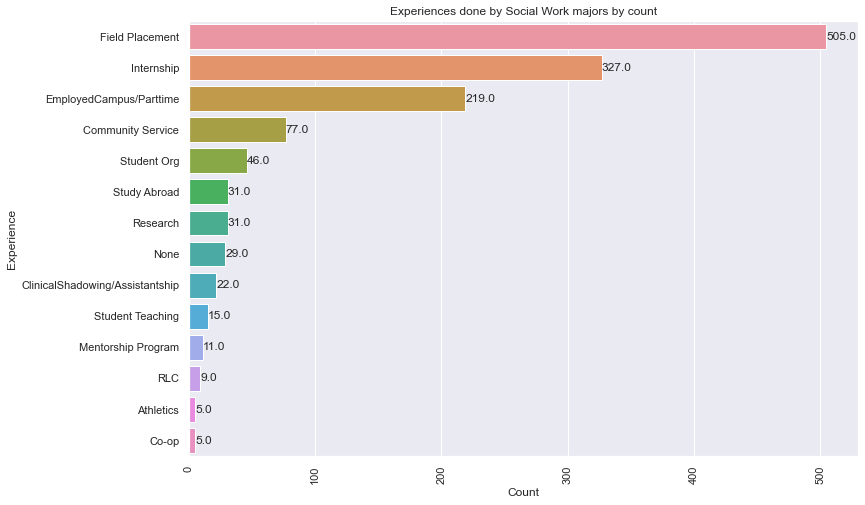

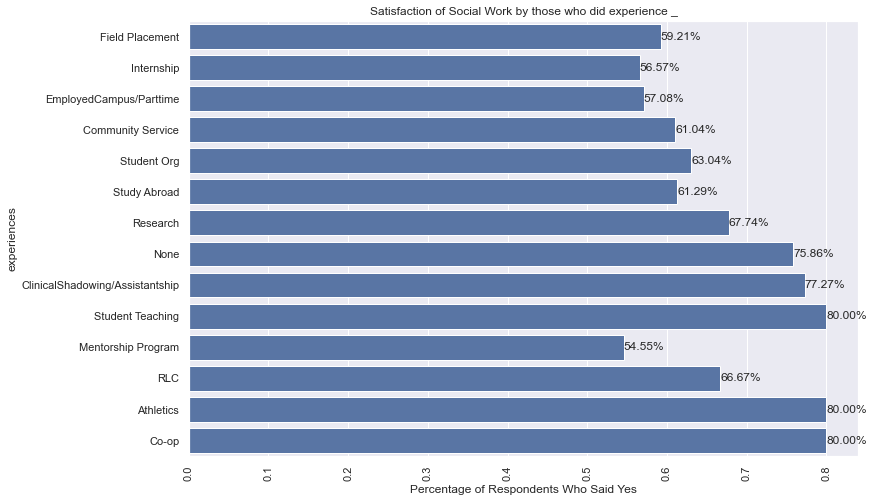

In [100]:
#Helper 6.1: Investigate how much doing an experience led to satisfaction for a major. 

#Method: Pick a major. Find count of each experience done by that major, 
#and how satisfied they were having done each experience. 

#Ex: What % of social work majors are satisfied having done each experience

def satisfactionWithExperiences(major):
    social_work_df = df[df['major'] == major][['experiences', 'post_grad_choice']].explode('experiences')
    value_counts = social_work_df['experiences'].value_counts().reset_index().rename(columns={'index': 'experiences', 'experiences': 'count'})

    # Create the bar plot of experience counts
    ax = sns.barplot(x='count', y='experiences', data=value_counts)
    for bar in ax.containers:
        for rect in bar.patches:
            count = rect.get_width()
            ax.text(count, rect.get_y() + rect.get_height() / 2, count, ha='left', va='center')
            plt.xticks(rotation=90)
            plt.title(f'Experiences done by {major} majors by count')
    plt.xlabel('Count')
    plt.ylabel('Experience')
    plt.show()

    # Compute the percentage of respondents who said 'Yes' for each experience
    percent_yes = social_work_df.groupby('experiences')['post_grad_choice'].value_counts(normalize=True).to_frame()
    percent_yes = percent_yes.rename(columns={'post_grad_choice': 'response'})
    odd_percent_yes = percent_yes.reset_index().iloc[::2, :]

    # Get the order of experiences from the value_counts dataframe
    order = value_counts['experiences'].tolist()

    fig, ax = plt.subplots()
    sns.barplot(x='response', y='experiences', data=odd_percent_yes, color='C0', dodge=False, order=order)
    ax.set_xlabel('Percentage of Respondents Who Said Yes')
    ax.set_title(f'Satisfaction of {major} by those who did experience _')

    for rect in ax.containers[0]:
        width = rect.get_width()
        height = rect.get_height()
        x = rect.get_x()
        y = rect.get_y()
        ax.text(x + width, y + height/2, f'{width:.2%}', ha='left', va='center')
    plt.xticks(rotation=90)
    plt.show()

satisfactionWithExperiences('Social Work')


In [101]:
#Helper 6.2: Investigate the effectiveness of an experience on a major for satisfaction versus other majors.

#Method: Pick a major and experience 

#Ex: Field Placement and Social Work majors.
#Analysis: Social Works majors are 10% less satisfied having done a field placement than other majors.

def satisfactionWithSpecificExperience(major,experience):
    df2= df.copy(deep=True)
    df2 = df2[df2['experiences'].apply(lambda x: experience in x)]
    
    majorGroup = df2[df2['major']==major]
    non = df2[df2['major']!=major]


    socHappy = round(100 * majorGroup[majorGroup['post_grad_choice']=='Yes'].shape[0] / majorGroup.shape[0],2)
    avgHappy = round(100*non[non['post_grad_choice']=='Yes'].shape[0] / non.shape[0],2)

    print(f"The average {major} major is ", socHappy, f"% satisfied after doing {experience}, while average non {major} major is: ", avgHappy,'%')
    
    
satisfactionWithSpecificExperience('Social Work', 'Field Placement')



The average Social Work major is  59.21 % satisfied after doing Field Placement, while average non Social Work major is:  69.83 %


In [102]:
#Helper 6.3: Investigate the effectiveness of an experience on a major for being in a status versus other majors.

#Method: Pick a major, experience, and status.

#Ex: How often does a Social Work major end up Seeking Employment after doing a Field Placement compared to other majors?

#Analysis:
#Social Work majors doing field placements ought to be investigated 
#for its efficacy in preventing unemployment compared to being done by other majors since 34.56% compared to 17.59%
#are seeking employment having done one compared to other majors.
def statusWithExperienceMajorComparison(major, experience, status):

    df2= df.copy(deep=True)

    df2 = df2[df2['experiences'].apply(lambda x: experience in x)]
    majorGroup = df2[df2['major']==major]
    non = df2[df2['major']!=major]

    socHappy = round(100 * majorGroup[majorGroup['post_grad_status']==status].shape[0] / majorGroup.shape[0],2)
    avgHappy = round(100 * non[non['post_grad_status']==status].shape[0] / non.shape[0],2)

    print(f'"The average {major} major has {status}', socHappy, f'% after doing {experience}, while average non {major} major has {status}', avgHappy, f'% after doing {experience}')


statusWithExperienceMajorComparison('Social Work','Field Placement','Seeking employment')


"The average Social Work major has Seeking employment 34.46 % after doing Field Placement, while average non Social Work major has Seeking employment 17.59 % after doing Field Placement


In [103]:
#General form of 6: 
#Pick an experience to investigate and change the threshold size

def satisfactionWithCountPerMajor(threshold, experience):

    #Take rows where they did a field placement
    filtered_df = df[df['experiences'].apply(lambda x: experience in x)]

    #Get the amount of each major who have done field placements
    major_counts = filtered_df['major'].value_counts()

    #Get the amount of those majors who are satisfied
    satisfied_counts = filtered_df[filtered_df['post_grad_choice'] == 'Yes']['major'].value_counts()

    count_data = {'Major': [], 'Count': [], 'Percentage_satisfied': []}

    #For each major, put in the major, # who did the experience, and % satisfied who did that exp from that major.
    for major, count in major_counts.iteritems():
        #Put in major name
        count_data['Major'].append(major)
        #Put in # of that major who did the experience
        count_data['Count'].append(count)

        #If there is a satisfied member of the major who did the experience, get % of the major who are satisfied
        if major in satisfied_counts:
            percentage = (satisfied_counts[major] / count) * 100
            count_data['Percentage_satisfied'].append(percentage)
        #if not, then that means everyone in that major who did the experience was unsatisfied, so put 0%.
        else:
            count_data['Percentage_satisfied'].append(0)

    data = pd.DataFrame(count_data)
    data = data[data['Percentage_satisfied'].notnull()].sort_values(by='Percentage_satisfied', ascending=False)

    #Show majors that have over 10 people who did the experience:
    return data[data['Count']>threshold]

    #This seems to imply that the effect of a field placement on English (84% who did field placement are satisfied)
    #is much bigger than its effect on Social Work majors (59.2% who did field placement are satisfied).

    #Note some majors such as Communication and Information have it even lower
    #(to inspect, change count to >10 rather than 20)

    #I introduced helper functions to investigate this further in 6.1, 6.2,and 6.3

satisfactionWithCountPerMajor(20,'Field Placement')

,Major,Count,Percentage_satisfied
3,English,25,84.000000
4,Biology,24,83.333333
2,Computer Science,64,73.437500
1,Psychology,64,70.312500
0,Social Work,505,59.207921


In [104]:
#Part 4: -------Appendix------

Text(0.5, 1.0, 'Percentage of people who did each experience by post-grad status')

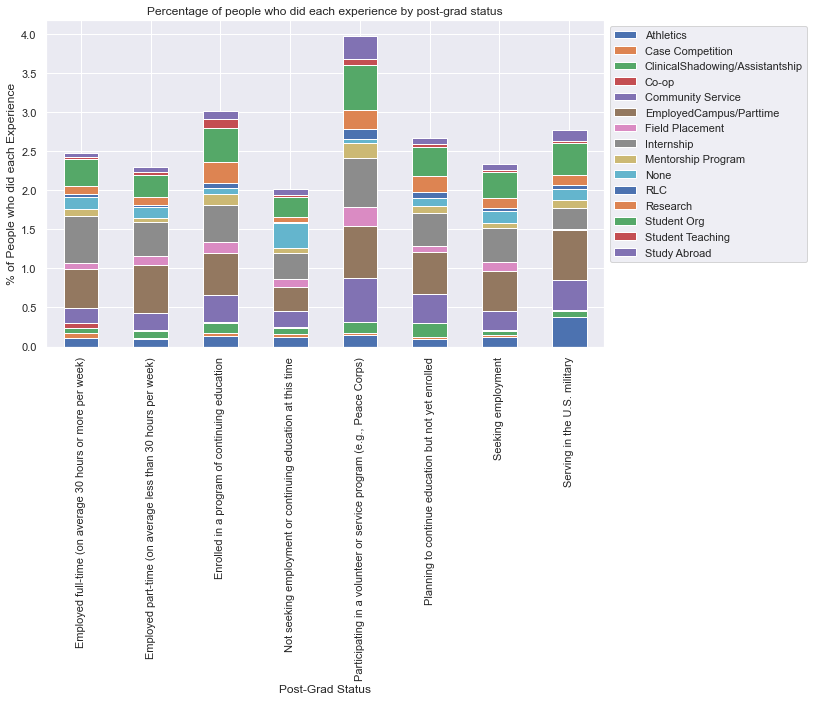

In [105]:
#Appendix 1: Show boxed stacks of experiences and post_grad_status

df2 = df.copy()

# Create new column with comma-separated experiences
df2['Experiences_str'] = df2['experiences'].apply(lambda x: ','.join(x))

# Explode the experiences column
exploded = df2.explode('experiences')

#% People who did each experience for each post-grad status
perc_by_postgrad = exploded.groupby(['experiences', 'post_grad_status'])['Experiences_str'].count() / df2.groupby('post_grad_status')['Experiences_str'].count()

# Reset index and pivot the table to make cols for each exp
perc_by_postgrad = perc_by_postgrad.reset_index().pivot(index='post_grad_status', columns='experiences', values='Experiences_str')

# Make a stacked bar plot
ax=perc_by_postgrad.plot(kind='bar', stacked=True, figsize=(10,6))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.xlabel('Post-Grad Status')
plt.ylabel('% of People who did each Experience')
plt.title('Percentage of people who did each experience by post-grad status')


In [106]:
#Appendix 2: Show boxed stacks of experiences and post_grad_status

#Quick dupe check that showed duplicates existed.       
multiEmploy= []
indexes=[]
index = 0
for x in df['experiences']:
    counter =0
    for y in x:
        if(y=='EmployedCampus/Parttime'):
            counter= counter+1
    if(counter>1):
        print('Found dupe employ')
        multiEmploy.append(x)
        indexes.append(index)
    index= index+1

    
#But this leads to 931 rows with double employedcampus/parttime. Which means I by accident either rewrote some other thing that isnt
#that for 931 rows at the beginning when fixing typos, or they have 931 dupes on a row.
#Lets investigate.

In [107]:
#Check dupes
#Print out how many times a row has EmployedCampus/Parttime in it


def getDupes(keyWord):
    dupes= []
    indexes=[]
    index = 0
    for x in df['experiences']:
        counter =0
        for y in x:
            if(keyWord in y):
                counter= counter+1
        if(counter>1):
            dupes.append(x)
            indexes.append(index)
            #print("counter is: ",counter,", for ",keyWord," in ", x)
        index= index+1
    return dupes, indexes


dupeIndices = []


#Maybe not
dupesClinical, indexes = getDupes('Clinical')
dupesClinical = df.iloc[indexes]
print("Clinical dupes: ",dupesClinical.shape[0])
dupeIndices.append(indexes)


dupesIntern, indexes = getDupes('Internship')
dupesIntern = df.iloc[indexes]
print("Intern dupes: ",dupesIntern.shape[0])

dupesStudyAbroad, indexes = getDupes('Study ab')
dupesStudyAbroad = df.iloc[indexes]
print("StudyAbroad dupes: ",dupesStudyAbroad.shape[0])


dupesField, indexes = getDupes('Field Placement')
dupesField = df.iloc[indexes]
print("Field Placement dupes: ",dupesField.shape[0])

dupesResearch, indexes = getDupes('Academic research')
dupesResearch = df.iloc[indexes]
print("Research dupes: ",dupesResearch.shape[0])

dupesCommunityS, indexes = getDupes('Community s')
dupesCommunityS = df.iloc[indexes]
print("CommunityService dupes: ",dupesCommunityS.shape[0])

dupesCase, indexes = getDupes('Case Competition')
dupesCase = df.iloc[indexes]
print("CaseComp dupes: ",dupesCase.shape[0])


dupesOrg, indexes = getDupes('Student org')
dupesOrg = df.iloc[indexes]
print("Student Org dupes: ",dupesOrg.shape[0])


dupesAthletics, indexes = getDupes('Athl')
dupesAthletics = df.iloc[indexes]
print("Athletics dupes: ",dupesAthletics.shape[0])

dupesStudentT, indexes = getDupes('Student tea')
dupesStudentT = df.iloc[indexes]
print("StudentTeaching dupes: ",dupesStudentT.shape[0])


dupesNone, indexes = getDupes('I did not')
dupesNone = df.iloc[indexes]
print("None dupes: ",dupesNone.shape[0])


dupesCoop, indexes = getDupes('Cooperative education experience')
dupesCoop = df.iloc[indexes]
print("Co-op dupes: ",dupesCoop.shape[0])


dupesFigs, indexes = getDupes('FIGS')
dupesFigs = df.iloc[indexes]
print("Figs dupes: ",dupesFigs.shape[0])

dupesSAES, indexes = getDupes('Student Access')
dupesSAES = df.iloc[indexes]
print("SAES dupes: ",dupesSAES.shape[0])


listDupeIndices = sum(dupeIndices, [])
df.iloc[listDupeIndices]

Clinical dupes:  0
Intern dupes:  0
StudyAbroad dupes:  0
Field Placement dupes:  0
Research dupes:  0
CommunityService dupes:  0
CaseComp dupes:  0
Student Org dupes:  0
Athletics dupes:  0
StudentTeaching dupes:  0
None dupes:  0
Co-op dupes:  0
Figs dupes:  0
SAES dupes:  0


,survey_semester,survey_year,post_grad_status,post_grad_status_fulltime,post_grad_choice,position_type,how_position,experiences,experiences_non_participation,school,major,major2,post_grad_prefer,internship_job,internship_relate


In [108]:
#Check dupes for OR typos
def getDupes2(keyWord1, keyWord2):
    dupes= []
    indexes=[]
    index = 0
    for x in df['experiences']:
        counter =0
        for y in x:
            if(keyWord1 in y or keyWord2 in y):
                counter= counter+1
        if(counter>1):
            dupes.append(x)
            indexes.append(index)
            #print("counter is: ",counter,", for ",keyWord," in ", x)
        index= index+1
    return dupes, indexes


dupesEmploy, indexes= getDupes2('On-camp','Employed part-ti')
dupesEmploy = df.iloc[indexes]
print("Employ dupes: ",dupesEmploy.shape[0])
dupeIndices.append(indexes)
        
#Maybe not
dupesMentorship, indexes = getDupes2('Mentorship', "mentor pr")
dupesMentorship = df.iloc[indexes]
print("Mentorship Program dupes: ",dupesMentorship.shape[0])
dupeIndices.append(indexes)

#Maybe not
dupesRLC, indexes = getDupes2('Residential', "Liv")
dupesRLC = df.iloc[indexes]
print("RLC dupes: ",dupesRLC.shape[0])

dupesGrad, indexes = getDupes2('Graduate assistantship', 'Teaching assistantship')
dupesGrad = df.iloc[indexes]
print("Graduate assistantship dupes: ",dupesGrad.shape[0])
dupeIndices.append(indexes)


Employ dupes:  0
Mentorship Program dupes:  0
RLC dupes:  0
Graduate assistantship dupes:  0


In [109]:
#Appendix 3: Hardcoded categories (leaves typos for 2021, and appendix inspected the typoes)

#Check that my softcoding is getting rid # of values by hardcoding nontypoes


#Standardize the names of the experiences across 2019, 2020, 2021 data.

# #2019
# df2019=df2019.replace({'Field Placement \(real-world experience, learned outside of the classroom usually consists of one or more internships, under the supervision of a services professionals': 'Field Placement'},regex=True)
# df2019=df2019.replace({'Athletics \(e.g. club sports, intramurals, varsity sports\)': 'Athletics'},regex=True)
# df2019=df2019.replace({'Internship \( temporary work experience which may yield academic credit and be related to career goals\)': 'Internship'},regex=True)
# df2019=df2019.replace({'Community service learning/volunteer work \(e.g. service organizations, soup kitchens\)': 'Community Service'},regex=True)
# df2019=df2019.replace({'Academic research/lab project \(e.g. Aresty research program or other research under the direction of a faculty member': 'Research'},regex=True)
# df2019=df2019.replace({'Student Access and Equity Signature Program \(e.g., Rutgers Future Scholars, ODASIS, McNair, etc.\)': 'SAES Program'},regex=True)
# df2019=df2019.replace({'On-campus employment/employed part-time while in school': 'EmployedCampus/Parttime'},regex=True)
# df2019=df2019.replace({'Student organization on campus \(e.g. professional development groups or cultural organizations\)': 'Student Org'},regex=True)
# df2019=df2019.replace({'Case competition \(students compete to provide the best solution to a business or education-related case study, usually on a team\)': 'Case Competition'},regex=True)
# df2019=df2019.replace({'Co-op \(Cooperative education experience is a full time paid positions in field of study that usually last one or more semester\)': 'Co-op'},regex=True)
# df2019=df2019.replace({'Graduate assistantship/teaching assistantship': 'GA/TA'},regex=True)
# df2019=df2019.replace({'Student teaching \(i.e. placement in a school for full-time teaching for a semester to complete an education program\)': 'Student Teaching'},regex=True)
# df2019=df2019.replace({'Residential learning community \(i.e. academic or professional development program where students live in the same building as mentors\)': 'RLC'},regex=True)
# df2019=df2019.replace({'Study abroad \(e.g. semester or summer abroad taking classes via a Rutgers-sponsored program or foreign exchange program\)': 'Study Abroad'},regex=True)
# df2019=df2019.replace({'I did not participate in any of the above': 'None'},regex=True)
# df2019=df2019.replace({'Clinical/hospital rotation \(job shadowing or assistantship in a physician clinic or hospital\)': 'ClinicalShadowing/Assistantship'},regex=True)
# df2019=df2019.replace({'FIGS \(First Year Interest Group Seminars, taught by upperclass students to first-year students\)': 'FIGS'},regex=True)
# df2019=df2019.replace({'University-sponsored mentor program \(e.g, Road to Wall Street\)': 'Mentorship Program'},regex=True)

# #2020
# df2020=df2020.replace({'On-campus employment \(e.g. federal work or other part-time on-campus paid position\)': 'EmployedCampus/Parttime'},regex=True)
# df2020=df2020.replace({'Internship \(Temporary work experience which may yield academic credit and be related to career goals\)': 'Internship'},regex=True)
# df2020=df2020.replace({'Student organization on campus \(e.g. professional development groups or cultural organizations\)': 'Student Org'},regex=True)
# df2020=df2020.replace({'Community service learning/volunteer work \(e.g. service organizations, soup kitchens\)': 'Community Service'},regex=True)
# df2020=df2020.replace({'Academic research/lab project \(e.g. Aresty research program or other research under the direction of a faculty member\)': 'Research'},regex=True)
# df2020=df2020.replace({'Athletics \(e.g. club sports, intramurals, varsity sports\)': 'Athletics'},regex=True)
# df2020=df2020.replace({'Field Placement \(real-world experience, learned outside of the classroom usually consists of one or more internships, under the supervision of a services professionals\)': 'Field Placement'},regex=True)
# df2020=df2020.replace({'Study abroad \(e.g. semester or summer abroad taking classes via a Rutgers-sponsored program or foreign exchange program\)': 'Study Abroad'},regex=True)
# df2020=df2020.replace({'Clinical/hospital rotation \(job shadowing or assistantship in a physicians clinic or hospital\)': 'ClinicalShadowing/Assistantship'},regex=True)
# df2020=df2020.replace({'Student teaching \(i.e. placement in a school for full-time teaching for a semester to complete an education program\)': 'Student Teaching'},regex=True)
# df2020=df2020.replace({'Living learning experience': 'RLC'},regex=True)

# #Bit different than 2019 for GA TA had RA also
# df2020=df2020.replace({'Graduate Assistantship \(Teaching Assistantship, Research Assistantship, Administrative Assistantship\)': 'GA/TA'},regex=True)
# df2020=df2020.replace({'Case competition \(students compete to provide the best solution to a business or education-related case study, usually on a team\)': 'Case Competition'},regex=True)
# df2020=df2020.replace({'Co-op \(Cooperative education experience - full time paid position in field of study that usually lasts one or more semesters\)': 'Co-op'},regex=True)
# df2020=df2020.replace({'Athletics \(e.g. club sports, intramurals, varsity sports\)': 'Athletics'},regex=True)
# df2020=df2020.replace({'I did not participate in any of the above': 'None'},regex=True)
# df2020=df2020.replace({'Mentorship programs': 'Mentorship Program'},regex=True)
# #Ignores the bottom value which has 2 entries of student org + RLC


# #2021 - add the first 16 distinct categories
# df2021=df2021.replace({'Internship \(Temporary work experience which may yield academic credit and be related to career goals\)': 'Internship'},regex=True)
# df2021=df2021.replace({'Employed part-time while in school \(e.g. on-campus employment or other part-time position completed while taking courses\)': 'EmployedCampus/Parttime'},regex=True)
# df2021=df2021.replace({'Mentorship programs': 'Mentorship Program'},regex=True)
# df2021=df2021.replace({'I did not participate in any of the above': 'None'},regex=True)
# #Can fix
# df2021=df2021.replace({'Clinical/hospital rotation \(job shadowing or assistantship in a clinic or hospital\)': 'ClinicalShadowing/Assistantship'},regex=True)
# df2021=df2021.replace({'Student organization on campus \(e.g. professional development groups or cultural organizations\)': 'Student Org'},regex=True)
# df2021=df2021.replace({'Athletics \(e.g. club sports, intramurals, varsity sports\)': 'Athletics'},regex=True)
# df2021=df2021.replace({'Living learning experience': 'RLC'},regex=True)
# df2021=df2021.replace({'Field Placement \(real-world experience, learned outside of the classroom usually consists of one or more internships, under the supervision of a services professionals': 'Field Placement'},regex=True)
# df2021=df2021.replace({'Academic research/lab project \(e.g. Aresty research program or other research under the direction of a faculty member': 'Research'},regex=True)
# df2021=df2021.replace({'Co-op \(Cooperative education experience - full time paid position in field of study that usually lasts one or more semesters\)': 'Co-op'},regex=True)
# df2021=df2021.replace({'Student teaching \(i.e. placement in a school for full-time teaching for a semester to complete an education program\)': 'Student Teaching'},regex=True)
# df2021=df2021.replace({'Living learning experience': 'RLC'},regex=True)
# df2021=df2021.replace({'Community service learning/volunteer work \(e.g. service organizations, soup kitchens\)': 'Community Service'},regex=True)
# df2021=df2021.replace({'Study abroad \(e.g. semester or summer abroad taking classes via a Rutgers-sponsored program or foreign exchange program\)': 'Study Abroad'},regex=True)
# df2021=df2021.replace({'Case competition \(students compete to provide the best solution to a business or education-related case study, usually on a team\)': 'Case Competition'},regex=True)



# #Display the counts of the experiences from the years
# dfExp=pd.DataFrame()

# dfExp['2019'] = df2019['experiences'].str.split('|').explode('experiences').value_counts()
# dfExp['2020'] = df2020['experiences'].str.split('|').explode('experiences').value_counts()
# dfExp['2021'] = df2021['experiences'].str.split('|').explode('experiences').value_counts()
# dfExp


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

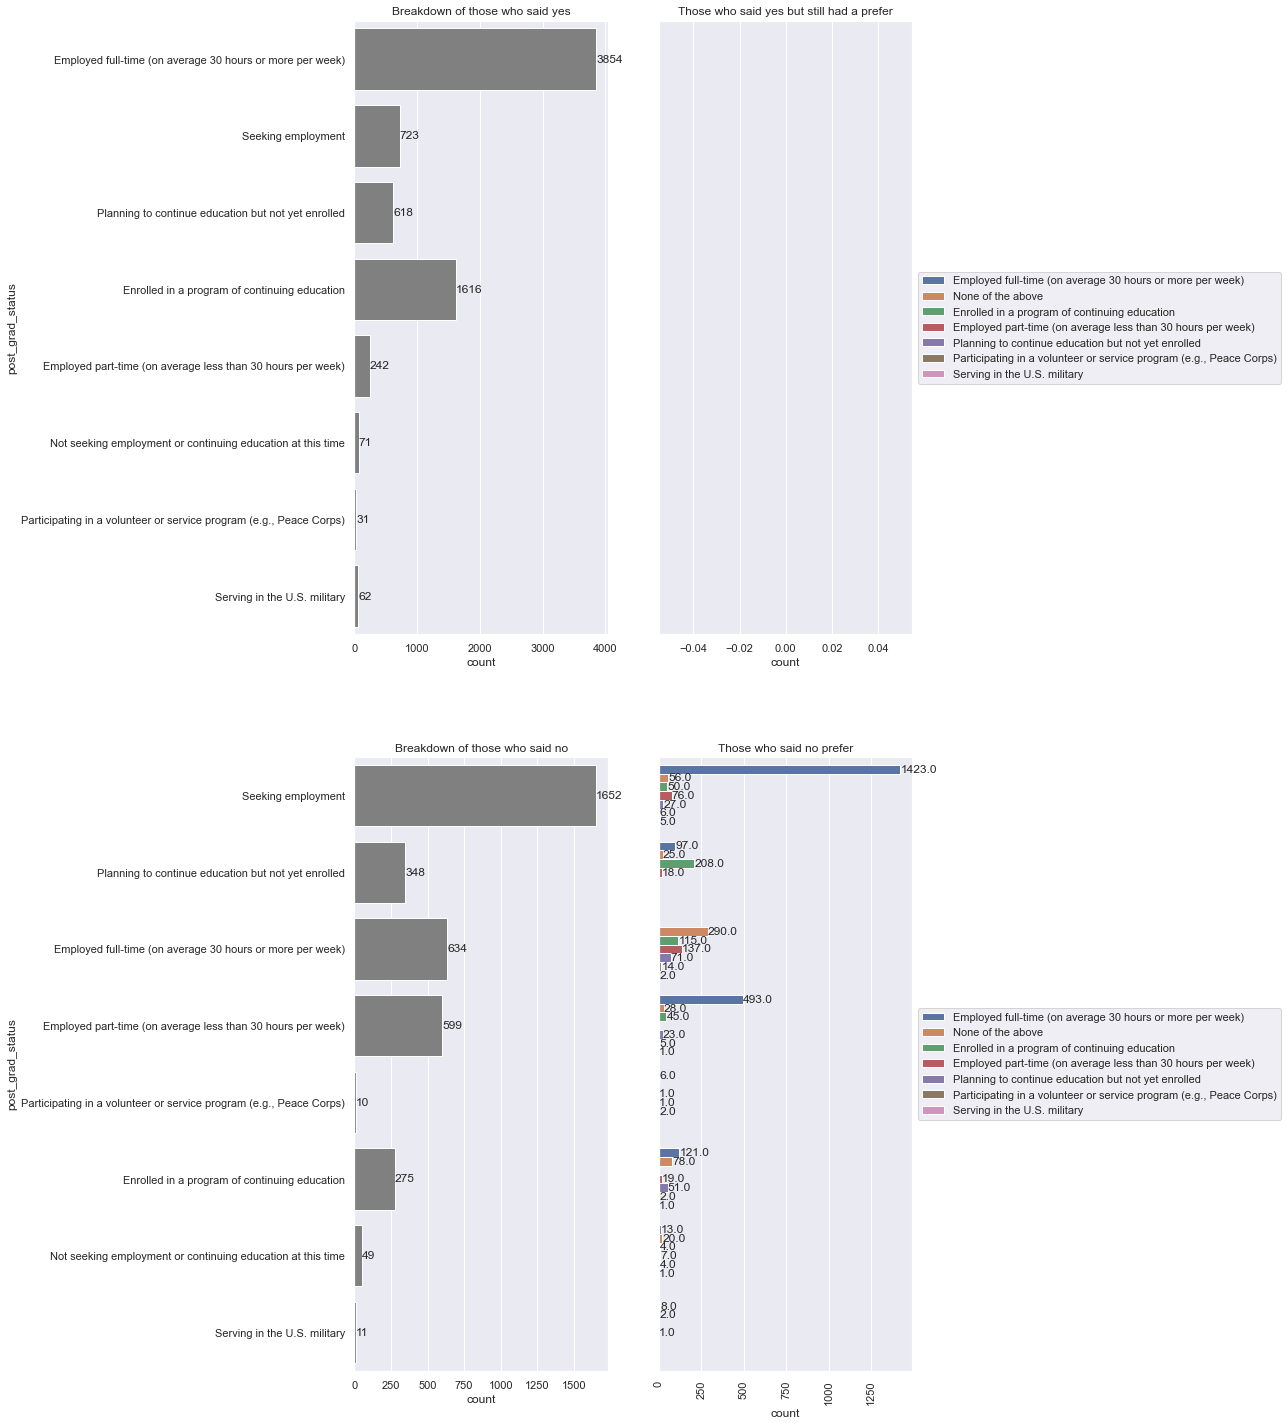

In [110]:
# Appendix 4: Graph showing what those who said yes prefer and those who said no prefer

# What do current status people prefer?

hue_order = df[df['post_grad_choice'] == 'No']['post_grad_prefer'].value_counts().index.tolist()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

countplot1 = sns.countplot(data=df[df['post_grad_choice'] == 'Yes'], y='post_grad_status', ax=axs[0, 0], palette=['grey'])
for bar in countplot1.containers:
    for rect in bar.patches:
        count = rect.get_width()
        if count > 0:
            axs[0, 0].text(count, rect.get_y() + rect.get_height() / 2, count, ha='left', va='center')
countplot1.set_title("Breakdown of those who said yes")

countplot3 = sns.countplot(data=df[df['post_grad_choice'] == 'Yes'], y='post_grad_status', hue='post_grad_prefer', hue_order=hue_order, ax=axs[0, 1])
for bar in countplot3.containers:
    for rect in bar.patches:
        count = rect.get_width()
        if count > 0:
            axs[0, 1].text(count, rect.get_y() + rect.get_height() / 2, count, ha='left', va='center')
countplot3.set_title("Those who said yes but still had a prefer")
countplot3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

countplot2 = sns.countplot(data=df[df['post_grad_choice'] == 'No'], y='post_grad_status', ax=axs[1, 0], palette=['grey'])
for bar in countplot2.containers:
    for rect in bar.patches:
        count = rect.get_width()
        if count > 0:
            axs[1, 0].text(count, rect.get_y() + rect.get_height() / 2, count, ha='left', va='center')
countplot2.set_title("Breakdown of those who said no")

countplot4 = sns.countplot(data=df[df['post_grad_choice'] == 'No'], y='post_grad_status', hue='post_grad_prefer', hue_order=hue_order, ax=axs[1, 1])
for bar in countplot4.containers:
    for rect in bar.patches:
        count = rect.get_width()
        if count > 0:
            axs[1, 1].text(count, rect.get_y() + rect.get_height() / 2, count, ha='left', va='center')
countplot4.set_title("Those who said no prefer")
countplot4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1, 1].set_ylabel('')
axs[0, 1].set_ylabel('')  
axs[0, 1].set_yticklabels([])
axs[1, 1].set_yticklabels([])

plt.subplots_adjust(top=2)
plt.xticks(rotation=90)




Computer Science is rank 12 with 70.9% satisfied, 29.1% unsatisfied.


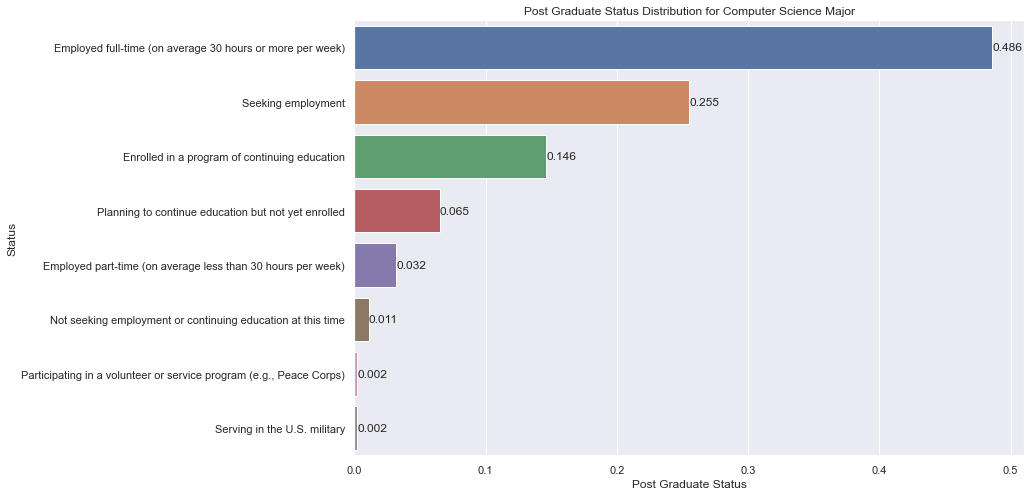

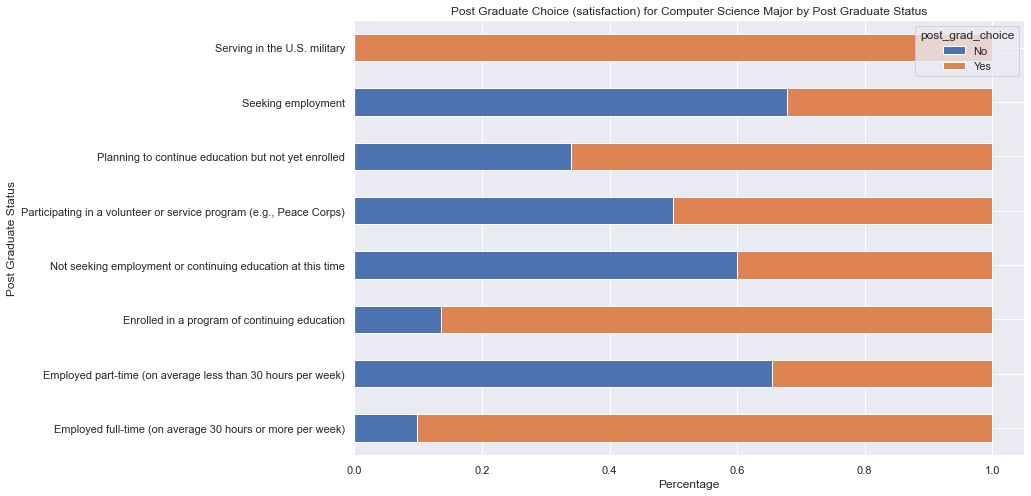

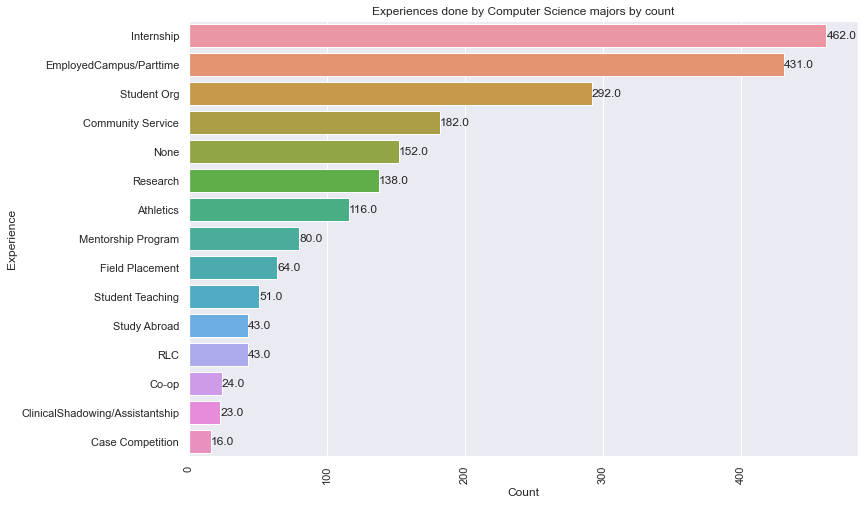

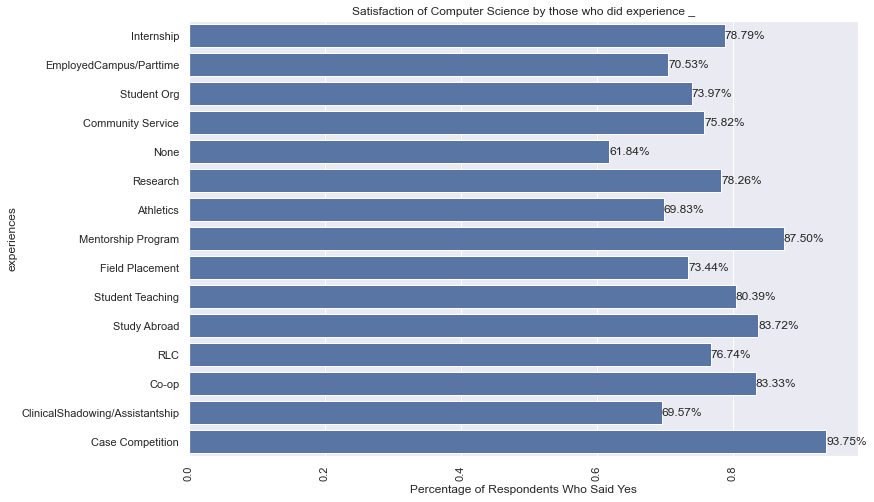

The average Computer Science major is  78.79 % satisfied after doing Internship, while average non Computer Science major is:  69.57 %
"The average Computer Science major has Employed full-time (on average 30 hours or more per week) 64.5 % after doing Internship, while average non Computer Science major has Employed full-time (on average 30 hours or more per week) 48.04 % after doing Internship
                                      Major  Count  Percentage_satisfied
41                                 Genetics     25             92.000000
54                   Industrial Engineering     18             88.888889
21      Electrical and computer engineering     74             86.486486
64   Urban Planning and  Policy Development     14             85.714286
65       Molecular Biology and Biochemistry     14             85.714286
..                                      ...    ...                   ...
22             Journalism and Media Studies     71             47.887324
63     Environment

In [117]:
#Appendix 5: Further example of using helper functions to analyze a major: Computer Science

major = 'Computer Science'


#How satisfied are they?
satisfaction(major, 50)

#What's their status?
statusBreakdown(major)

#How satisfied are they in their statuses?
statusSatisfactionBreakdown(major)

# #In a table, how does doing each experience lead to status?
# table = experienceStatusTableForMajor(major)
# table

#What experiences do they do and how satisfied are they after doing them?
satisfactionWithExperiences(major)

#Let's look into internship. 78.8% are satisfied. Is that above average compared to other majors?
satisfactionWithSpecificExperience(major, 'Internship')

#Is that due to them being more full time after interning than others?
statusWithExperienceMajorComparison(major, 'Internship', 'Employed full-time (on average 30 hours or more per week)')

#Generally, how does doing an internship relate to a major's satisfaction? 
#Lets look at majors that have at least 10 people who did an internship
print(satisfactionWithCountPerMajor(10, 'Internship'))

#Design looks low. What rank is satisfaction are they?
satisfaction('Design',50)

#Oh, too low. Okay, let's use 30 then.
satisfaction('Design',30)

#Huh, rank 65. What's rank 1 with 30 responses?
getMajorByRank(1,30)
